In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma
from subprocess import call

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

plt.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [51]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
# Make sure we have halo information for this z... hop/...
num = 73 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
z   = 10.0

print("***** Cm in Mpc {:.3e}, RAMSES uses 3.08e24 *****".format((1 * u.Mpc.to(u.cm))))
print("Using astropy cosmology: physical size {:.2f}".format((3 * u.Mpc/0.71/(1.0+z)).to(u.kpc)))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Physical Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]
print("Boxsize in comoving coords per h = {}".format(boxsizekpc * (z+1) * 0.71 ))

rho_critDMz = myCosmo.critical_density(z) * myCosmo.Odm(z)
print('rho_critdm,z = {:.3e}'.format(rho_critDMz))

gc.collect()

***** Cm in Mpc 3.086e+24, RAMSES uses 3.08e24 *****
Using astropy cosmology: physical size 384.12 kpc
Physical Boxsize from kKey file = 383.42 kpc
Boxsize in comoving coords per h = 2994.5102
Boxsize in comoving coords per h = 2999.9772
rho_critdm,z = 2.799e-27 g / cm3


22

In [36]:
locsRaw

array([[ -95.97782871,  -56.59018078,  -99.8496275 ],
       [ -95.97097948,  -56.58621897,  -99.84940917],
       [ -95.95494069,  -56.59796692,  -99.85570233],
       ..., 
       [  48.84041476,  -62.12399193, -182.75176927],
       [  48.84040844,  -62.12421279, -182.75165585],
       [  48.84026497,  -62.13022063, -182.74847738]])

In [35]:
boxsizekpc * 11 * 0.71

2994.5101999999997

In [16]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
rho0 = myCosmo.critical_density0 * Odm # rho0 * O_DM --- Crit density in DM TODAY... Need to scale to redshift.
rho0/Odm
# Check critical density 'today' - Looks correct!

<Quantity 9.469372730554712e-30 g / cm3>

In [17]:
dmPartMass = 5.58e4 * Odm / h0 * u.Msun
print("DM particle mass {:.2f}".format(dmPartMass))
def totMass(numParts):
    return dmPartMass * numParts

DM particle mass 17447.32 solMass


In [18]:
# Example computation... 
haloTotMass = dmPartMass * 50863 # Halo 0, z=12
overDens = 100.0
size = ((haloTotMass * 3.0/(4.0 * ma.pi) * 1.0/(rho_critDMz * overDens))**(1.0/3.0)).to(u.kpc) * (1 + z)
# size = size * 0.5
size

<Quantity 40.85630933965904 kpc>

In [19]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
# fpol = 1.0-PPF
# fpol[fpol < 1e-5] = 0.0 # Don't form polluted stars when fpol is very small

# Z_corr = Z/fpol
# Z_corr[np.isinf(Z_corr)] = 0.9e-5 # Make the Z of the particles < Z_crit (1e-5)
# Z_corr[Z_corr < 1e-5]    = 0.9e-5 # Place them all just below Z_crit
gc.collect()

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


36

In [52]:
# Convert to comoving kpc ... we've divided out the h here so we have units of kpc
locs = (locsRaw/boxsizekpc) * 3000.0 # Comoving PER h, coords of SPs 

In [53]:
locs.max()

1499.6305034013067

In [54]:
# Compute age of the star particles...
# spAges is in Myr ... 

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
print("base age {:.2f}".format(baseAge))
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))
print("max sp Z {:.2e} mass frac".format(max(Z) * 0.02))

base age 485.54
min sp age -0.21 Myr
max sp age 286.43 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.90e-01 Solar
max sp Z 3.81e-03 mass frac


In [55]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 10.0, 0.0213 arcsec / kpc:
Proper to 10.0, 0.2340 arcsec / kpc:
Proper to 10.0, 4.2743 kpc / arcsec:
My Comoving @ 10.0, 0.0213 arcsec / kpc:
My Proper to 10.0, 0.2340 arcsec / kpc:
My Proper to 10.0, 4.2743 kpc / arcsec:


In [56]:
myCosmo.age(z)

<Quantity 0.48455407831727154 Gyr>

In [57]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
## Scale locations to co-moving coordates
## ## ## GET FROM hopRick ## ## ##
## THESE HALOS ARE BASED ON STAR PARTICLE LOCATIONS ##
##
halosRawPos = lsp.loadHaloGrps(num,prefix='/Users/earnric/RAMSES-Data/27Aug15-3Mpc/hopRick/') # Returns positions normalized to (-0.5, 0.5)
halossizes = lsp.loadHaloSizes(num,prefix='/Users/earnric/RAMSES-Data/27Aug15-3Mpc/hopRick/') # Returns positions normalized to (-0.5, 0.5)
halosRawPosDM = lsp.loadHaloGrps(num,prefix='/Users/earnric/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)
halossizesDM = lsp.loadHaloSizes(num,prefix='/Users/earnric/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPos = halosRawPos     * 3000.0 # Comoving box per h
halosPosDM = halosRawPosDM * 3000.0 # Comoving box per h
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

Num of halos @ 10.0 = 133


18858

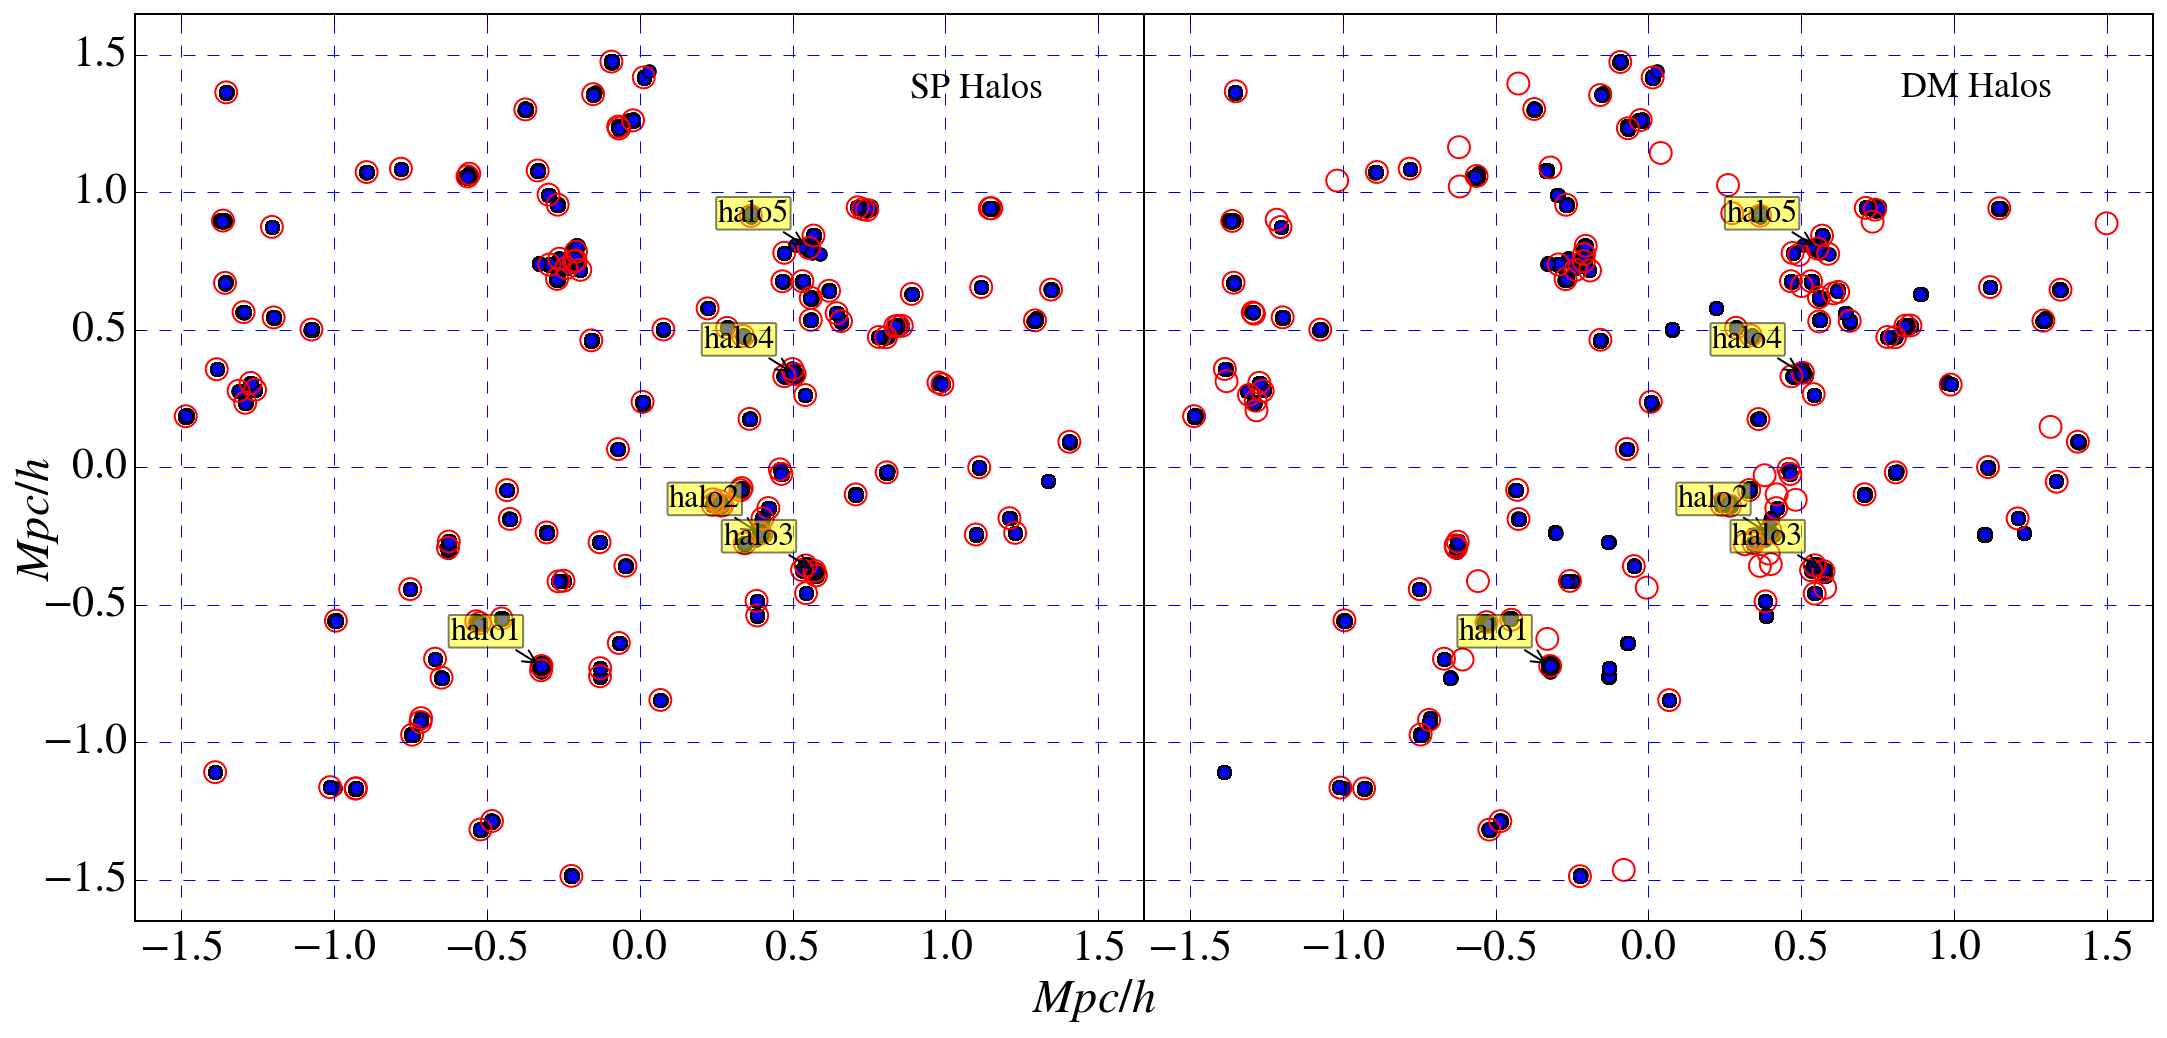

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row',figsize=(15,7))

htp = min(200,len(halosRawPos))
labels = ['halo{0}'.format(i+1) for i in range(len(halosPos))]
ax1.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
ax1.scatter(halosPos[:htp,0]/1000,halosPos[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
ax1.grid(b=True, which='major', color='b', linestyle='--')

ax2.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
ax2.scatter(halosPosDM[:htp,0]/1000,halosPosDM[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
ax2.grid(b=True, which='major', color='b', linestyle='--')

ax1.set_xlim([-1.65,1.65])
ax1.set_ylim([-1.65,1.65])
ax2.set_xlim([-1.65,1.65])
ax2.set_ylim([-1.65,1.65])

# plt.title('z=%.1lf stars & halo finder'%z)
for idx, (label, x, y) in enumerate(zip(labels, halosPos[:htp,0][:5]/1000,halosPos[:htp,1][:5]/1000)):
#     if idx%5 == 0:
#         continue
    ax1.annotate(
        label, xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=16,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax2.annotate(
        label, xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=16,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

fig.text(0.01, 0.5, '$Mpc/h$', size=24, va='center', rotation='vertical')
fig.text(0.51, 0.01, '$Mpc/h$', size=24, ha='center')

ax1.annotate("SP Halos", xy = (0.9, 0.9), xycoords = 'axes fraction', ha = 'right', va = 'bottom', fontsize=18)
ax2.annotate("DM Halos", xy = (0.9, 0.9), xycoords = 'axes fraction', ha = 'right', va = 'bottom', fontsize=18)

plt.subplots_adjust(left=0.066, bottom=0.1, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("allHalos.pdf",dpi=fig.dpi,bbox_inches='tight')
plt.savefig("allHalos.png",dpi=fig.dpi,bbox_inches='tight')
gc.collect()
 

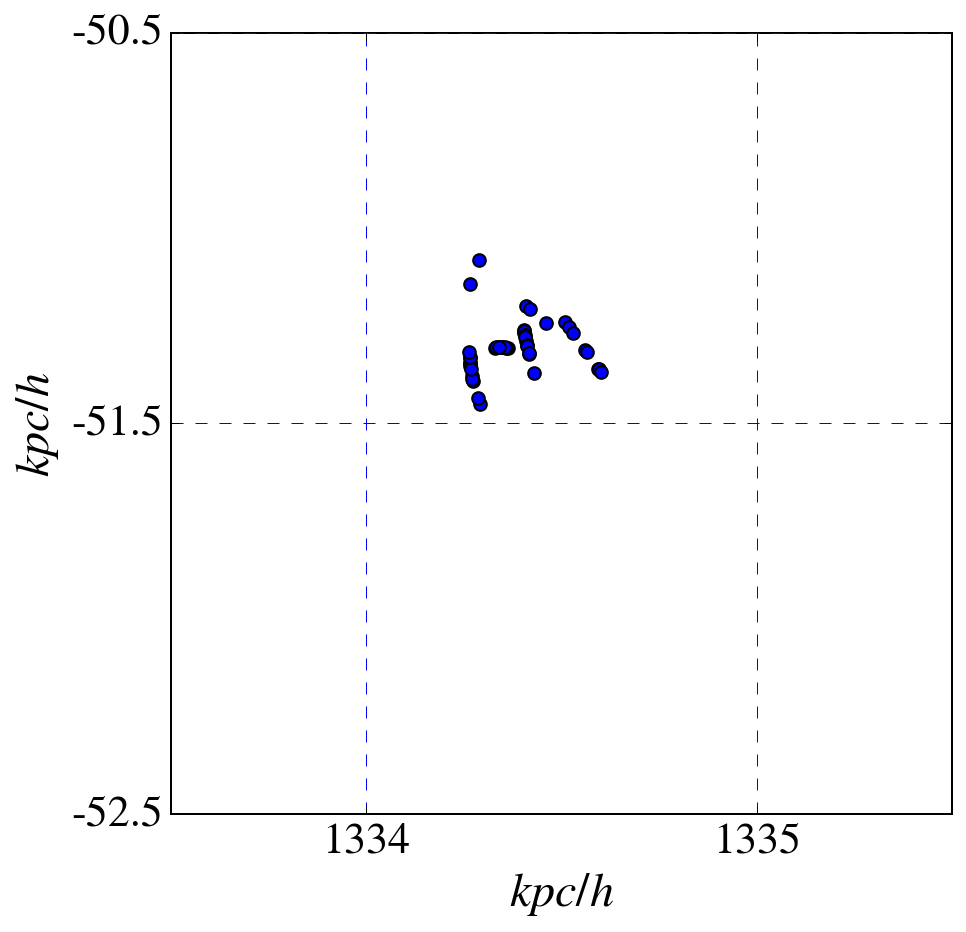

In [92]:
fig, ax1 = plt.subplots(figsize=(7,7))


ax1.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
ax1.grid(b=True, which='major', color='b', linestyle='--')
ax1.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs

ax1.set_xlim([1333.5,1335.5])
ax1.set_ylim([-52.0,-50.5])

ax1.xaxis.set_ticks([1334,1335])
ax1.set_xticklabels([1334,1335])
ax1.yaxis.set_ticks([-52.5,-51.5,-50.5])
ax1.set_yticklabels([-52.5,-51.5,-50.5])

ax1.set_xlabel('$kpc/h$', size=24)
ax1.set_ylabel('$kpc/h$', size=24)


In [118]:
133/2048.

0.06494140625

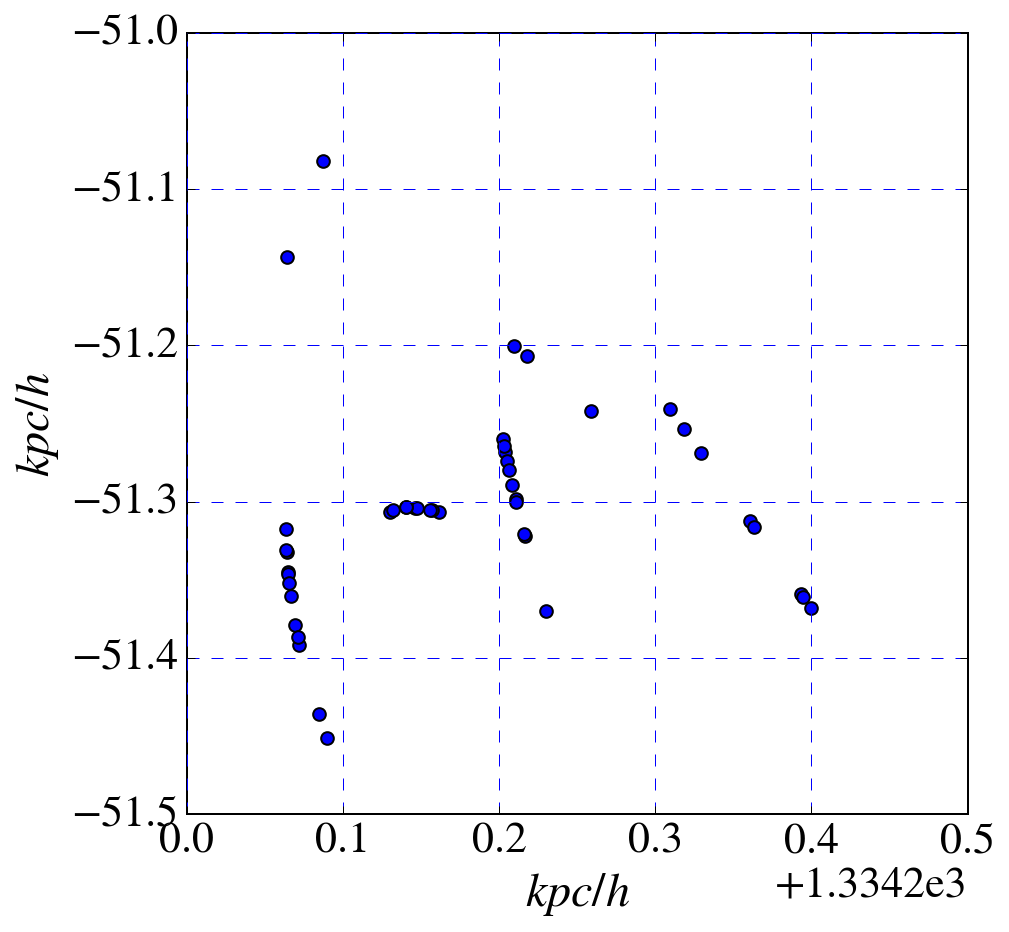

In [99]:
fig, ax1 = plt.subplots(figsize=(7,7))


ax1.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
ax1.grid(b=True, which='major', color='b', linestyle='--')
ax1.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs

ax1.set_xlim([1334.2,1334.7])
ax1.set_ylim([-51.5,-51.0])

ax1.set_xlabel('$kpc/h$', size=24)
ax1.set_ylabel('$kpc/h$', size=24)


In [110]:
lostStars = mass[(locs[:,0] > 1334.2) & (locs[:,0] < 1335)]

In [113]:
lostStars.size,lostStars.sum()

(45, 37005.159265707174)

In [116]:
lostStars.sum()/45

822.33687257127053

radius 21.47
Halo mass 0 is 7.12e+06
radius 16.51
Halo mass 1 is 3.25e+06
radius 15.66
Halo mass 2 is 2.68e+06
radius 14.00
Halo mass 3 is 0.00e+00
radius 13.83
Halo mass 4 is 1.85e+06
radius 11.75
Halo mass 5 is 1.13e+06
radius 11.66
Halo mass 6 is 1.11e+06
radius 11.33
Halo mass 7 is 1.03e+06
radius 11.12
Halo mass 8 is 9.70e+05
radius 11.06
Halo mass 9 is 9.44e+05
radius 10.64
Halo mass 10 is 8.38e+05
radius 9.83
Halo mass 11 is 6.65e+05
radius 9.60
Halo mass 12 is 6.22e+05
radius 9.53
Halo mass 13 is 6.21e+05
radius 9.50
Halo mass 14 is 5.81e+05
radius 9.49
Halo mass 15 is 6.02e+05
radius 9.47
Halo mass 16 is 5.93e+05
radius 9.23
Halo mass 17 is 5.47e+05
radius 8.99
Halo mass 18 is 5.28e+05
radius 8.93
Halo mass 19 is 5.07e+05


/Users/earnric/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


713

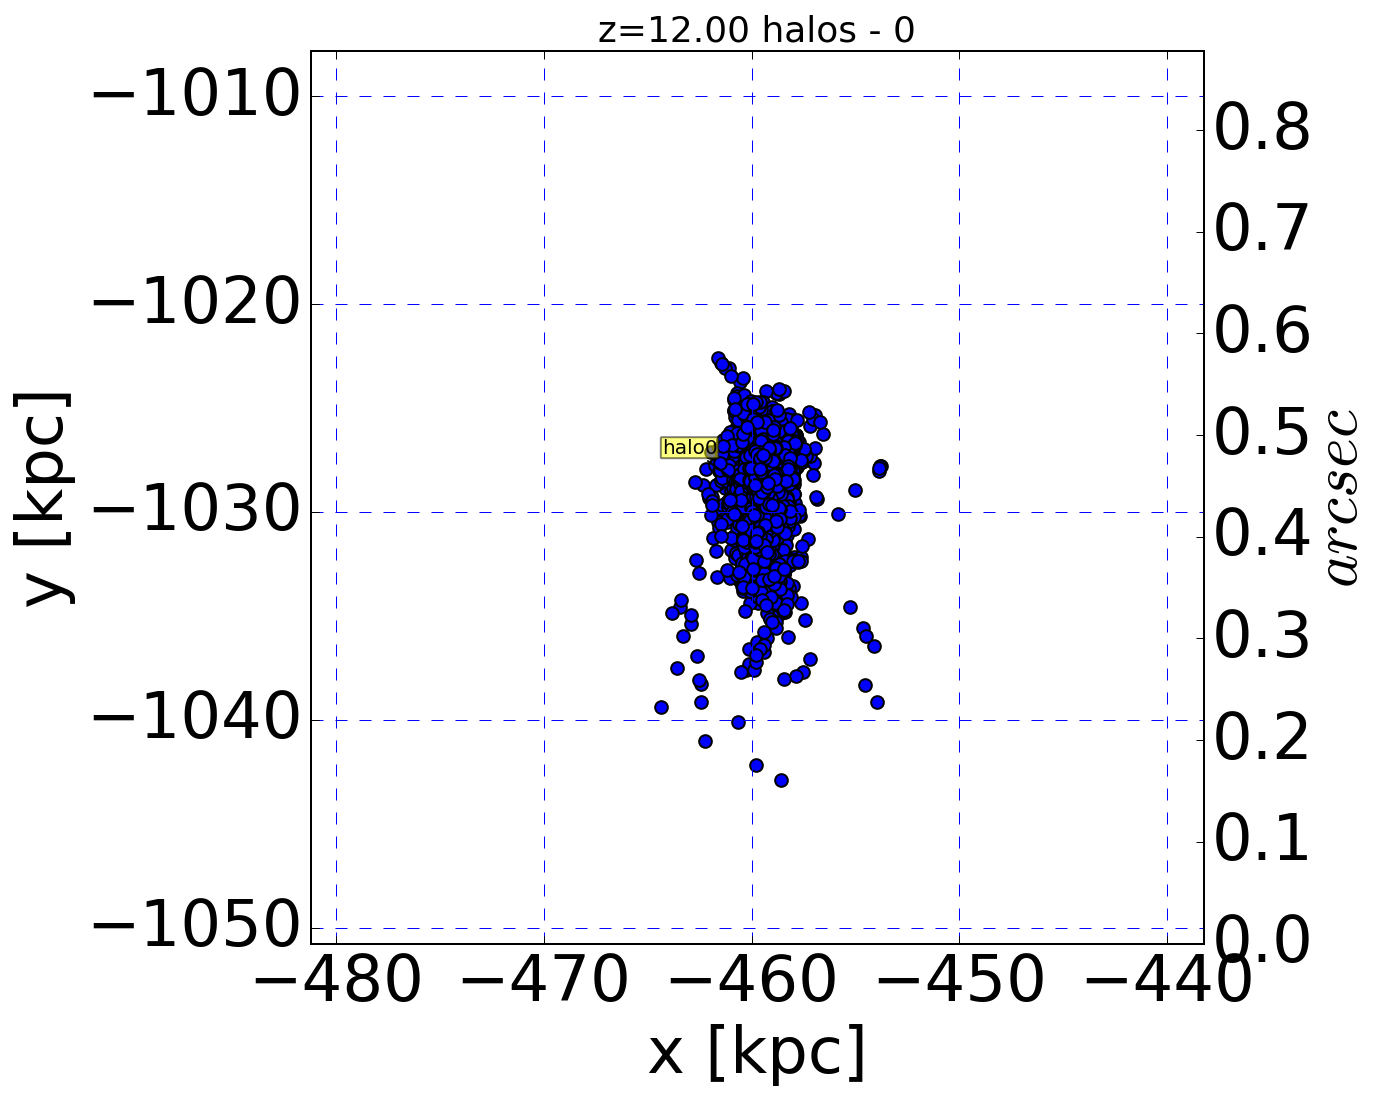

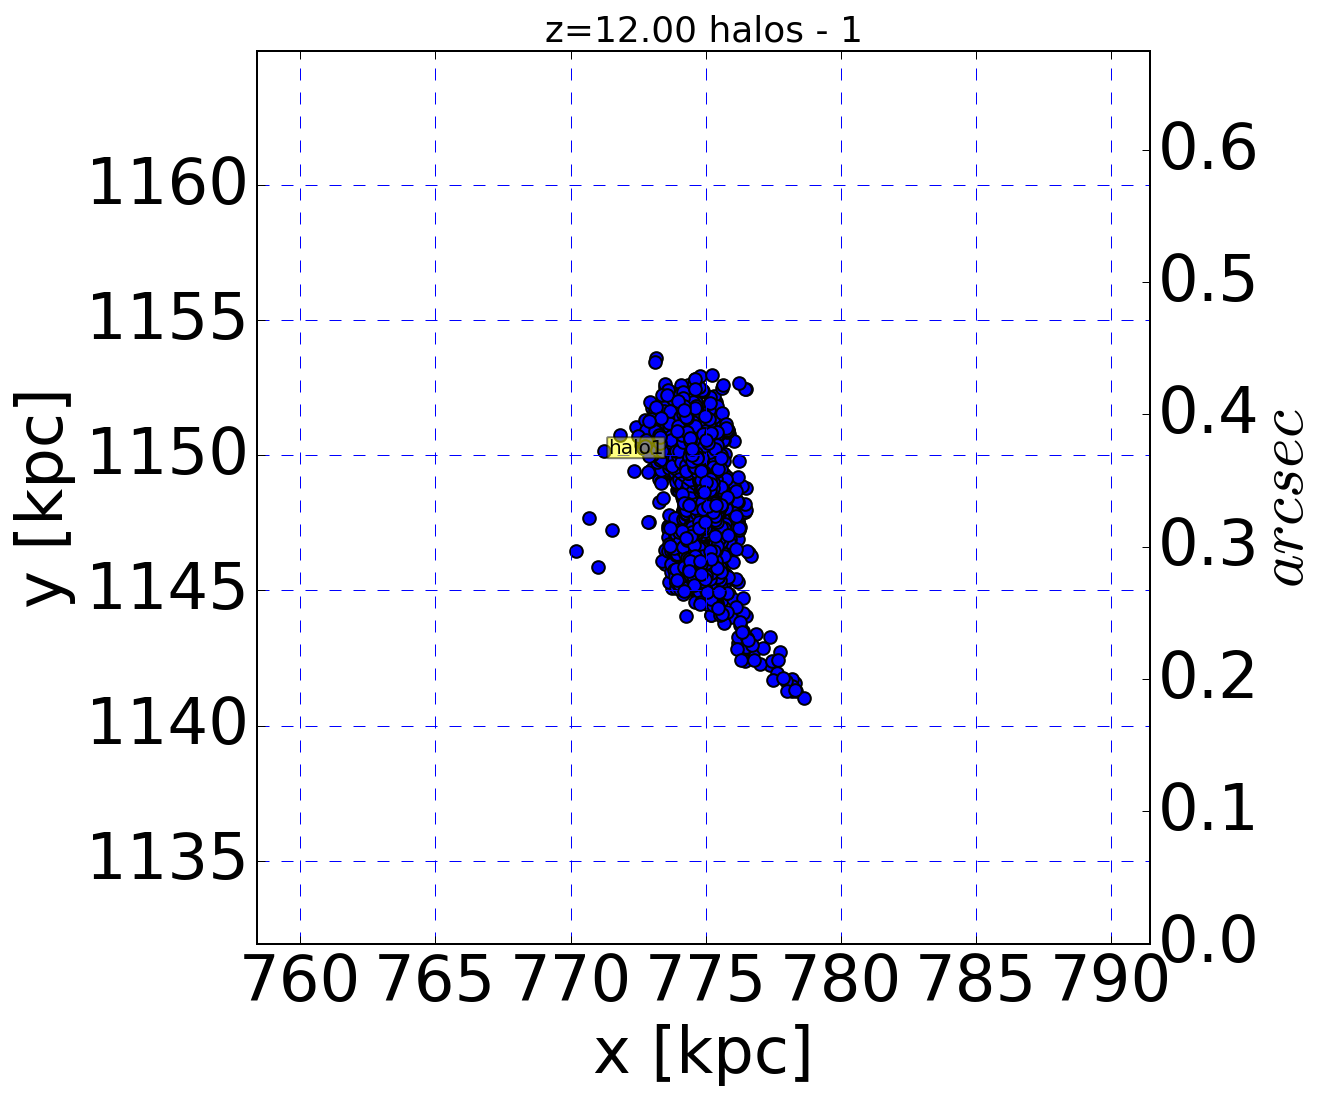

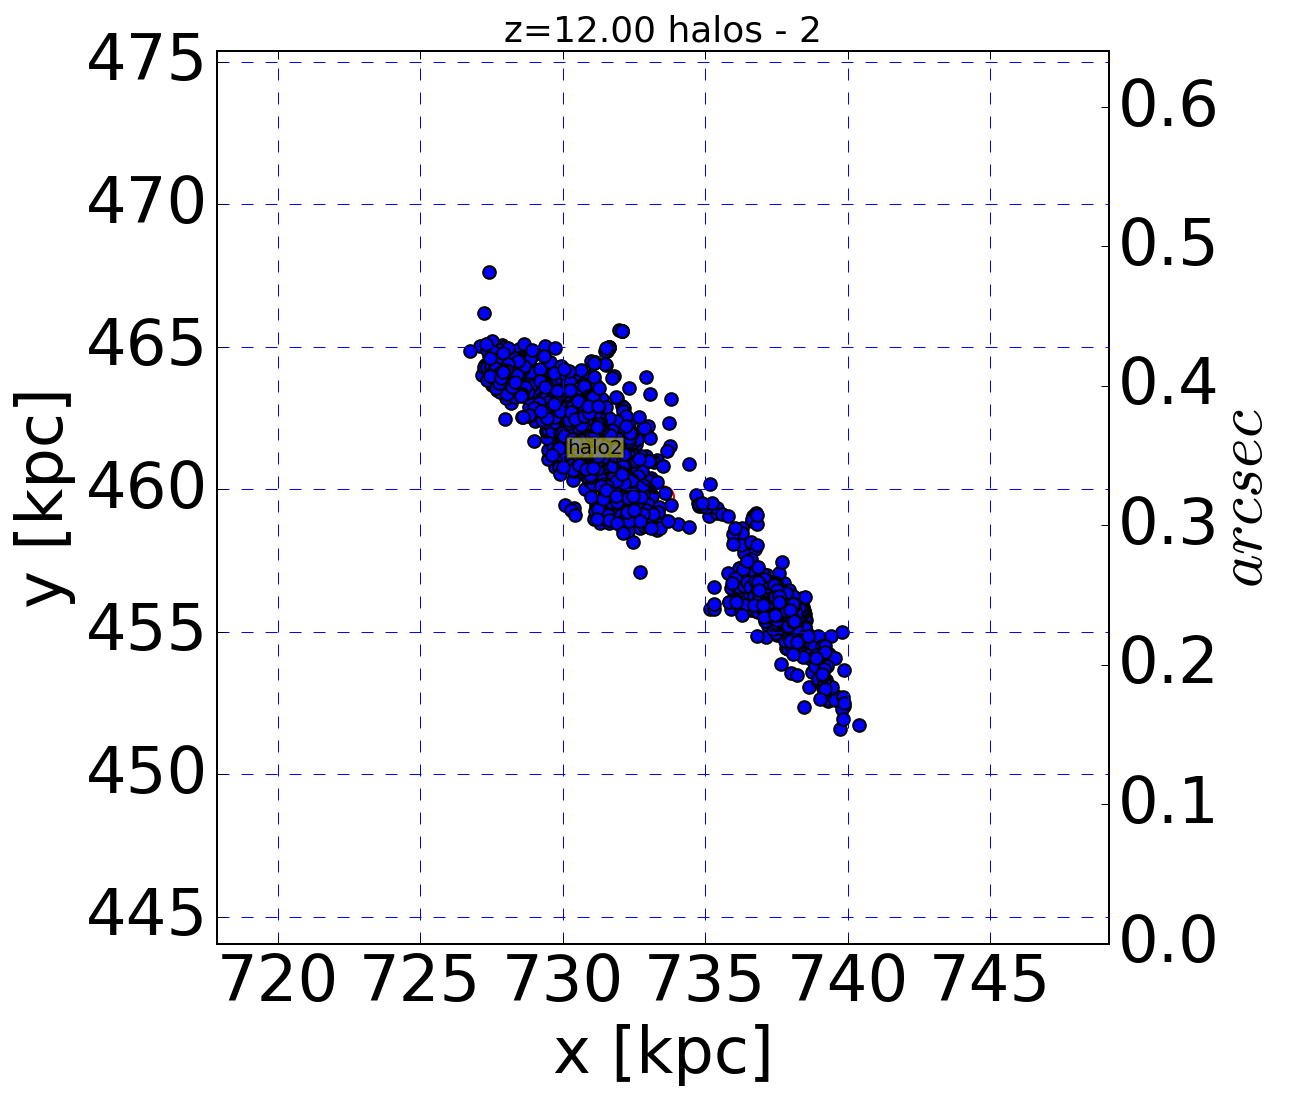

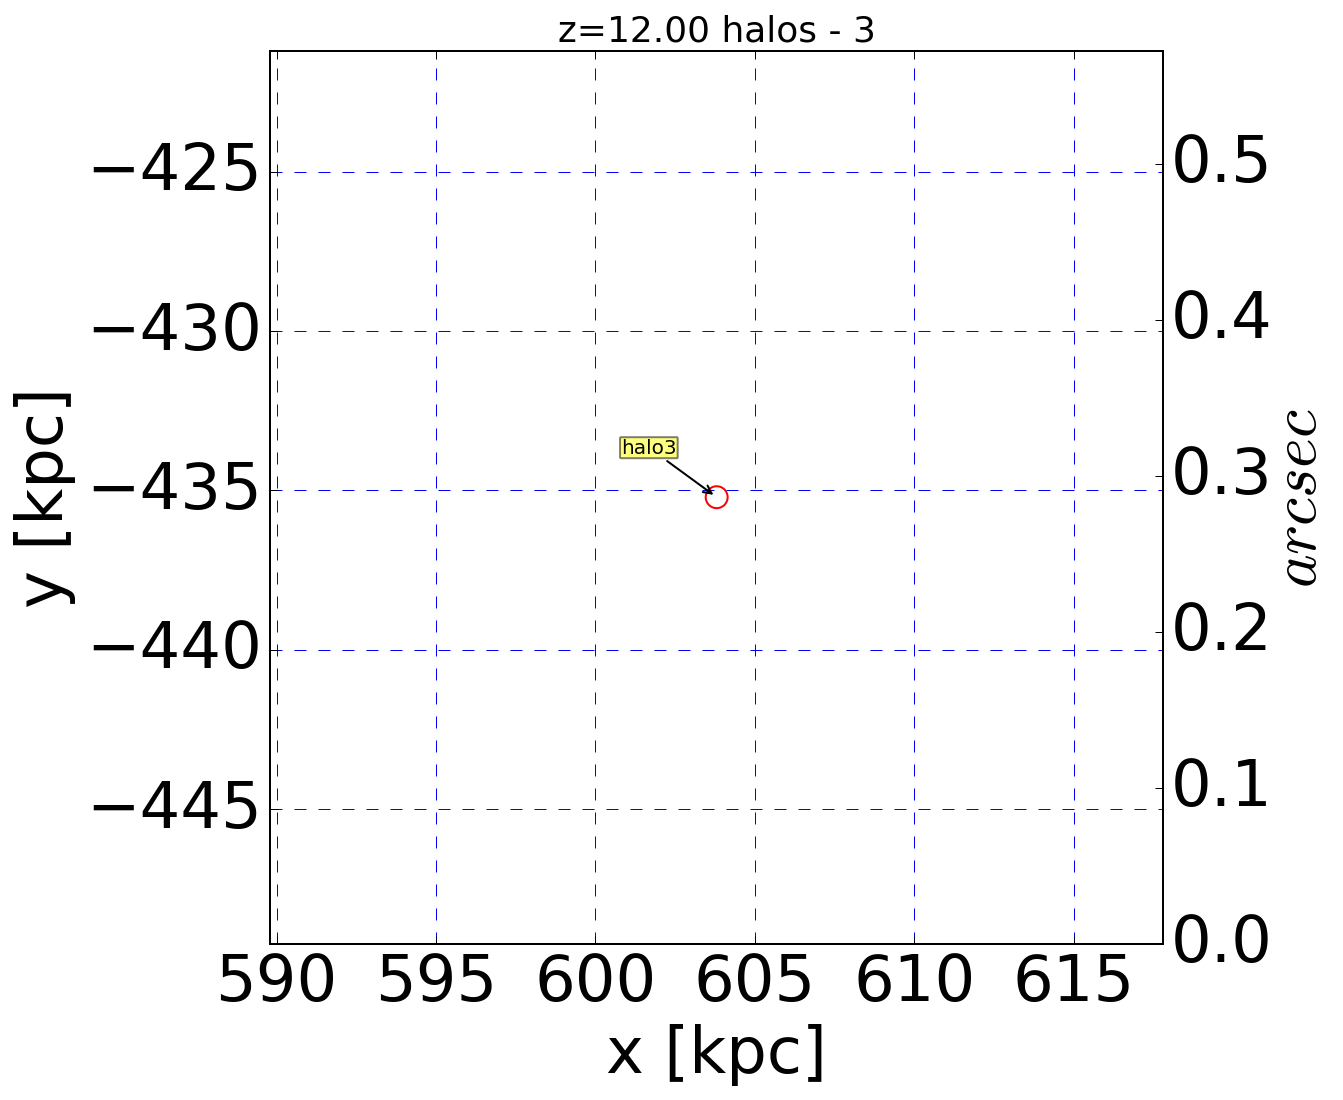

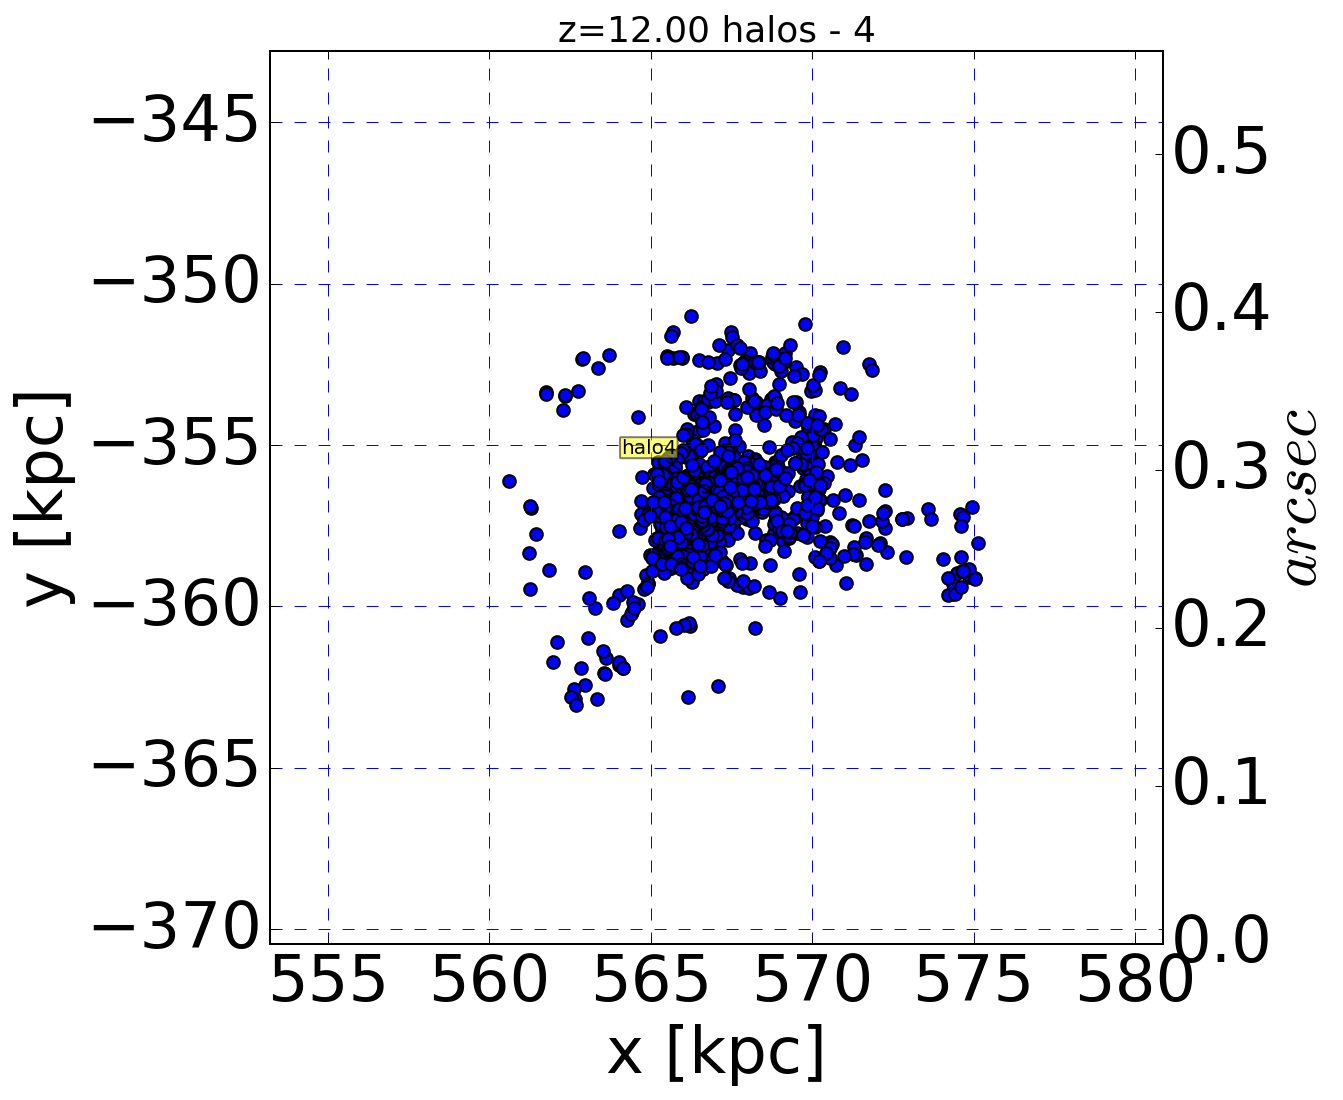

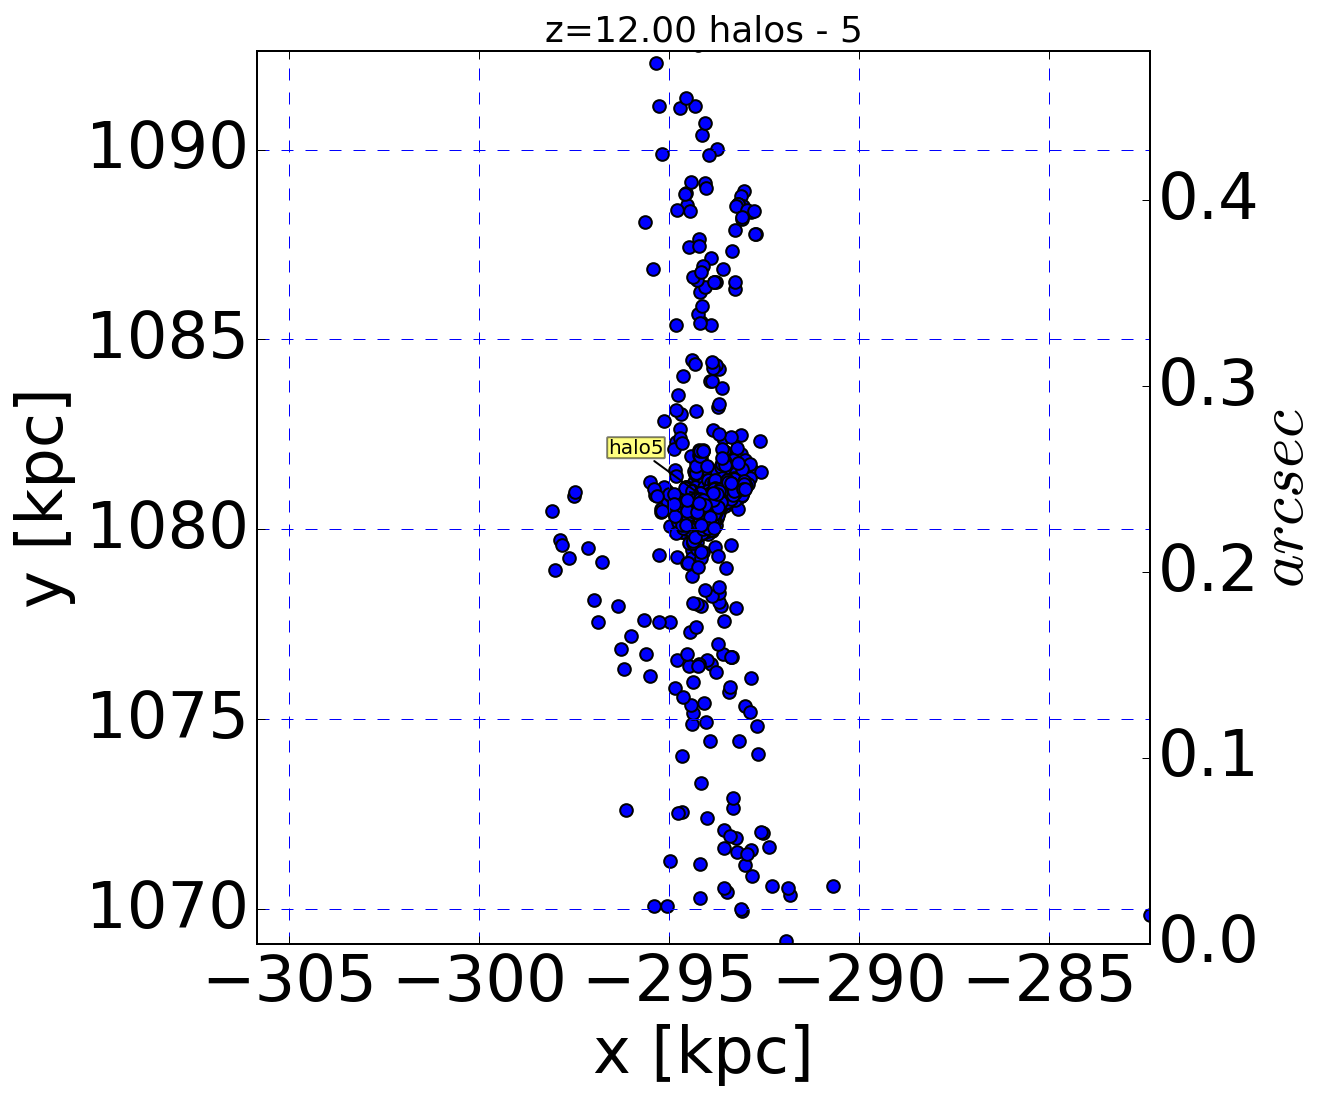

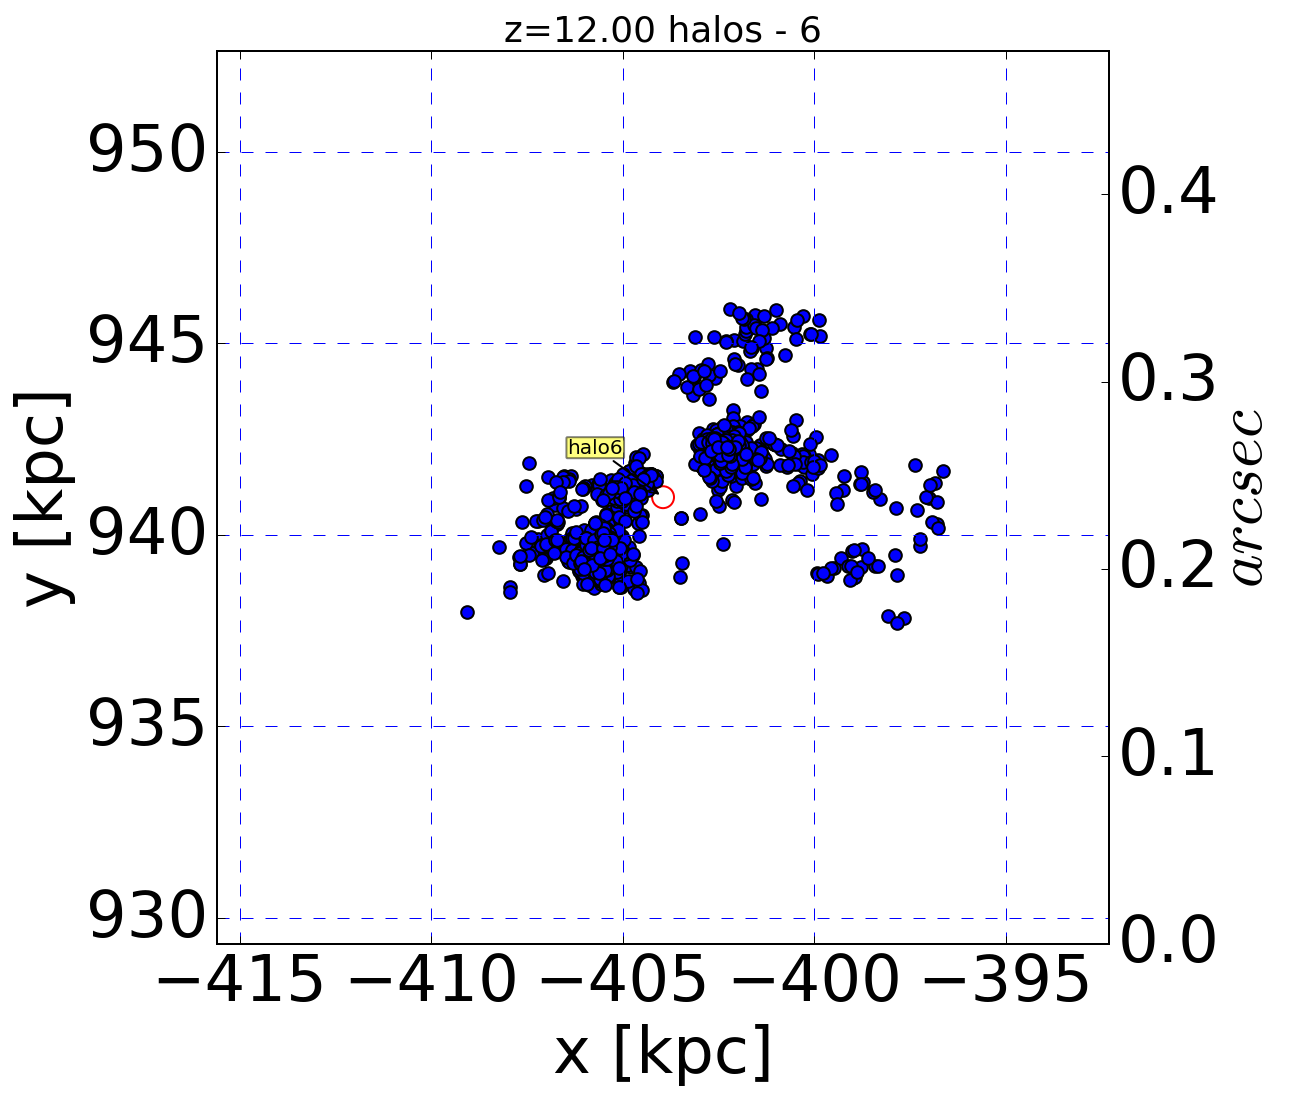

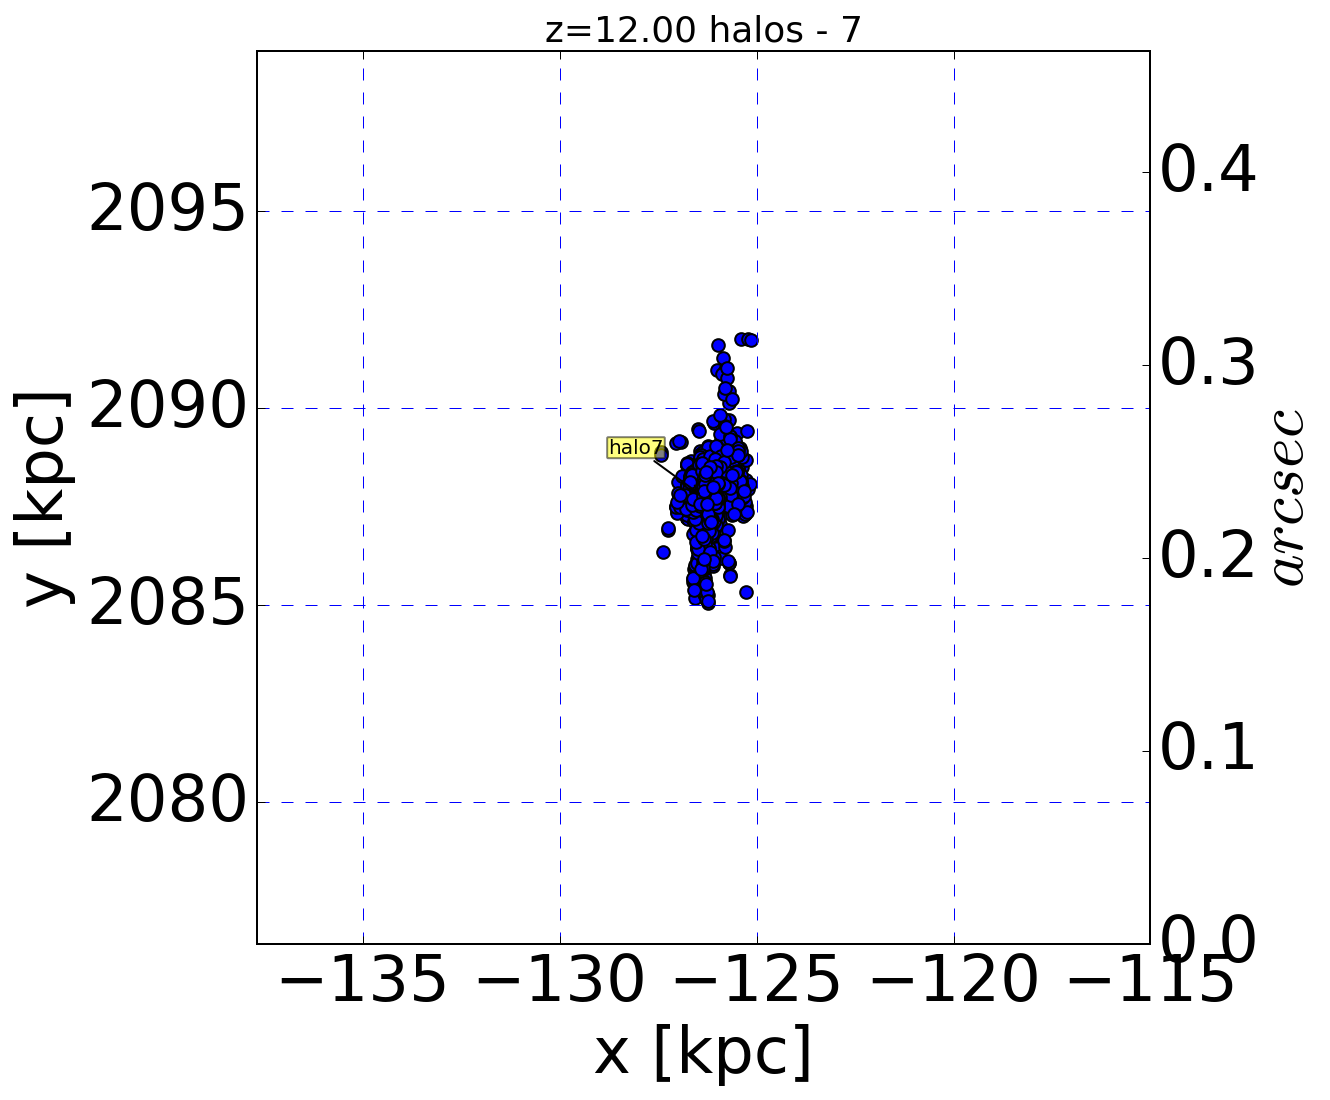

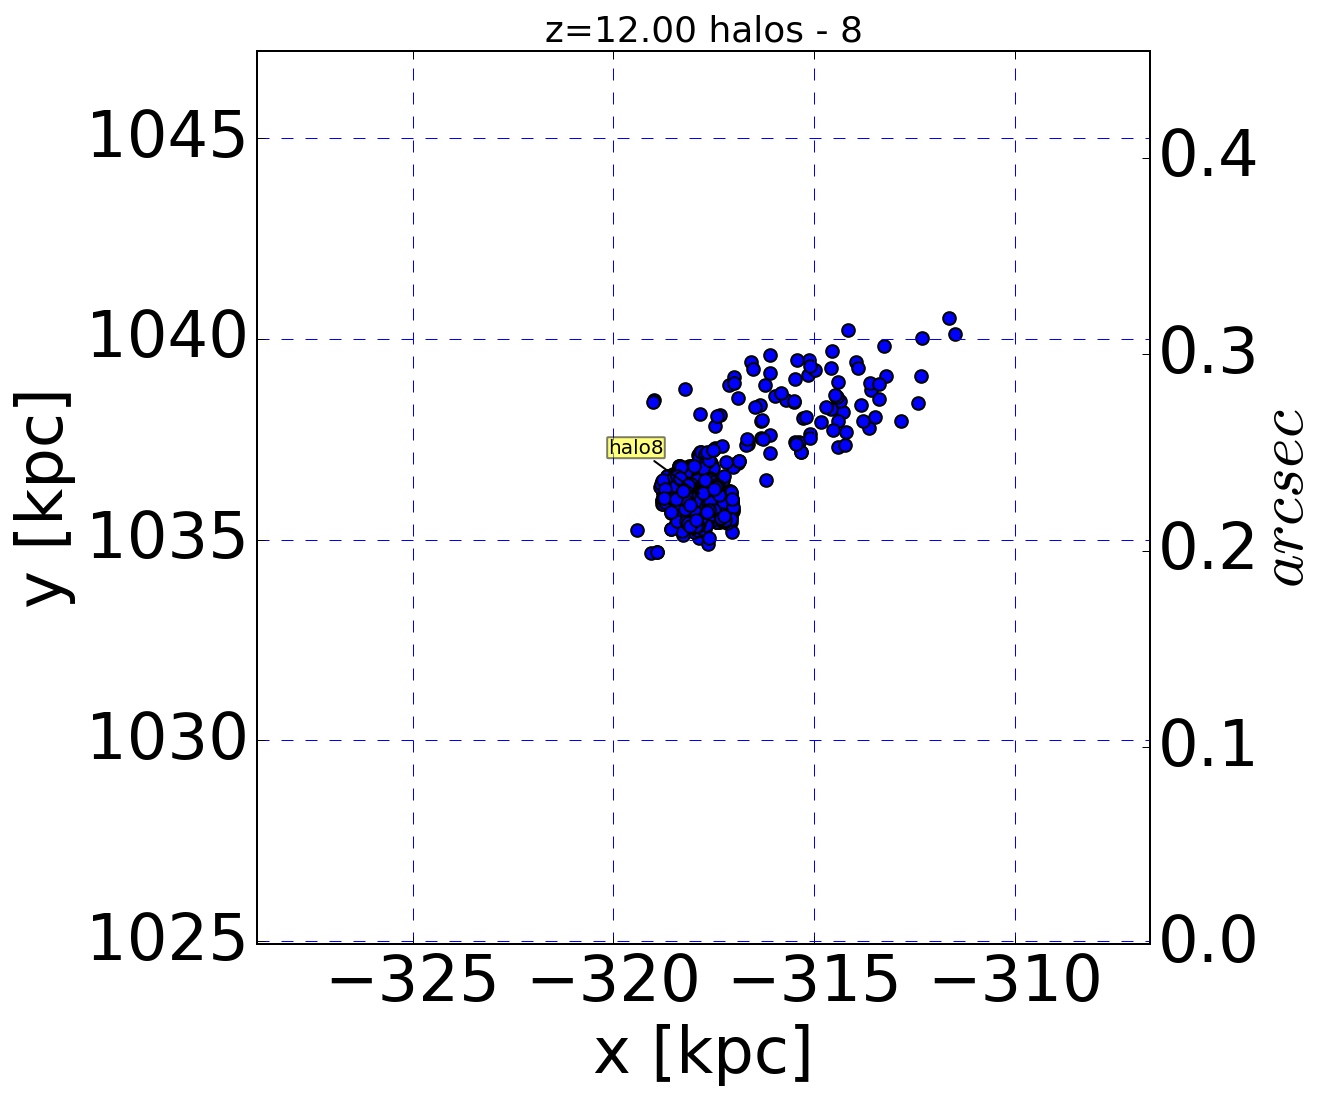

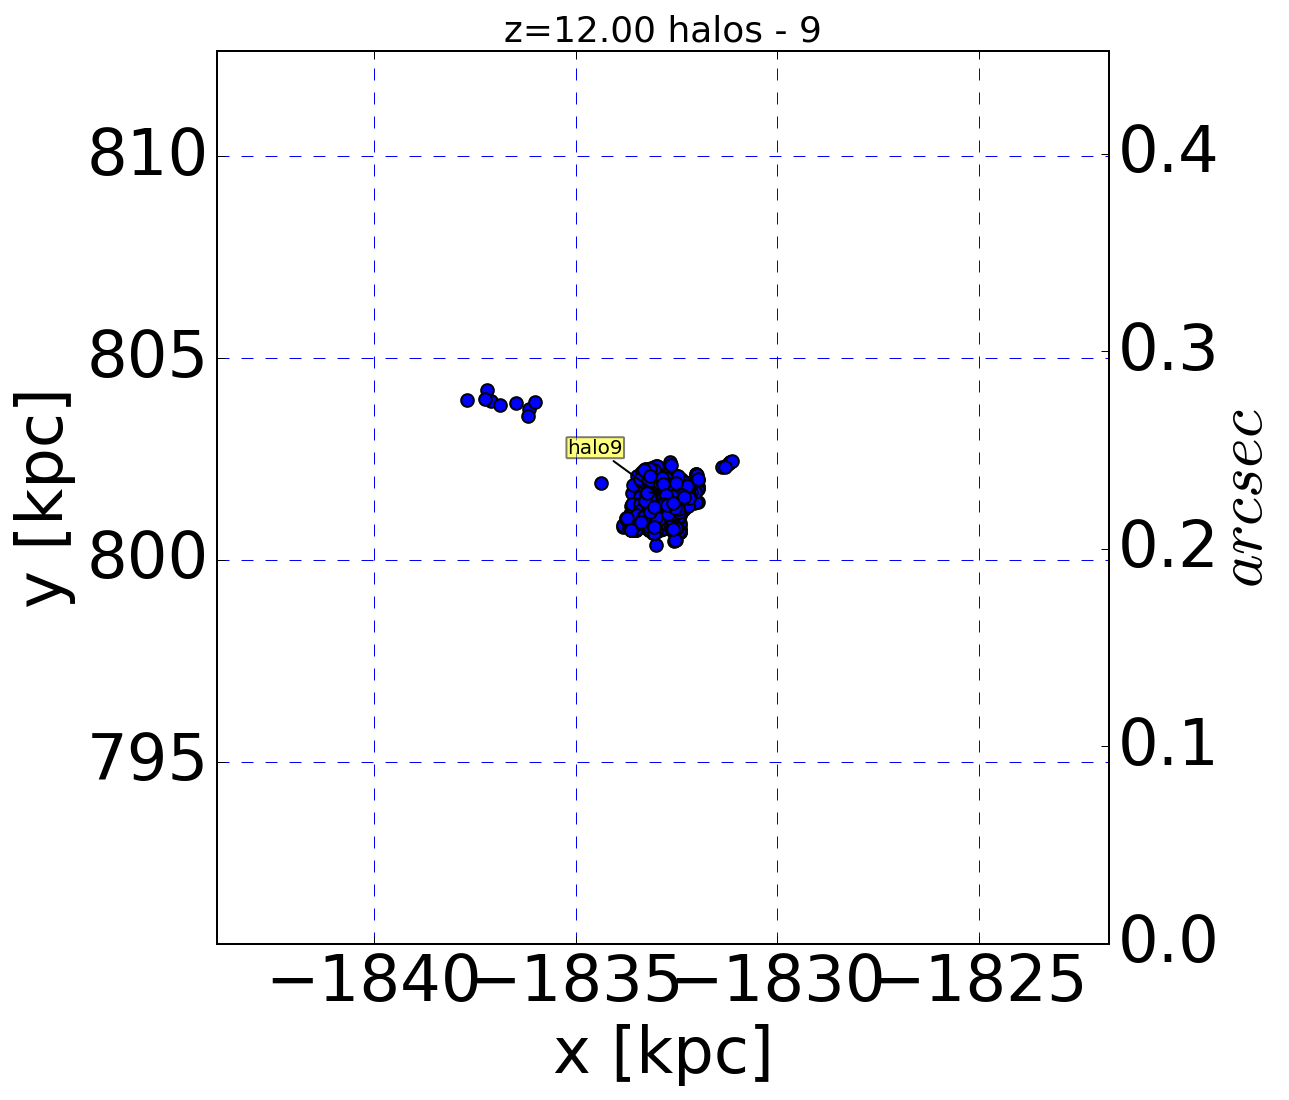

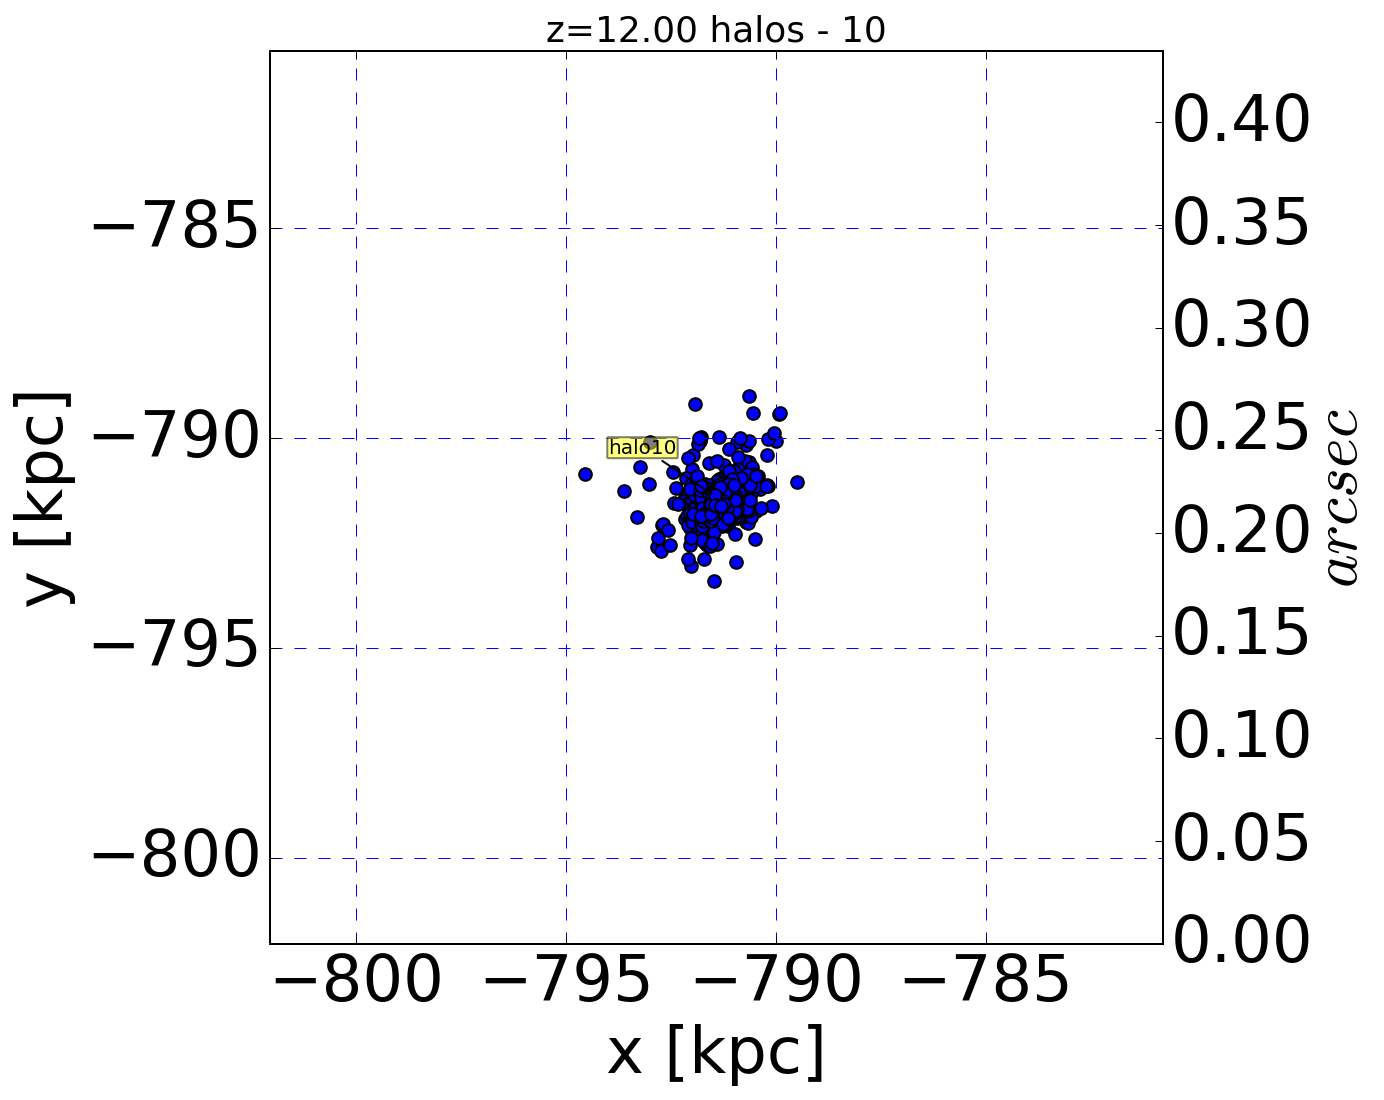

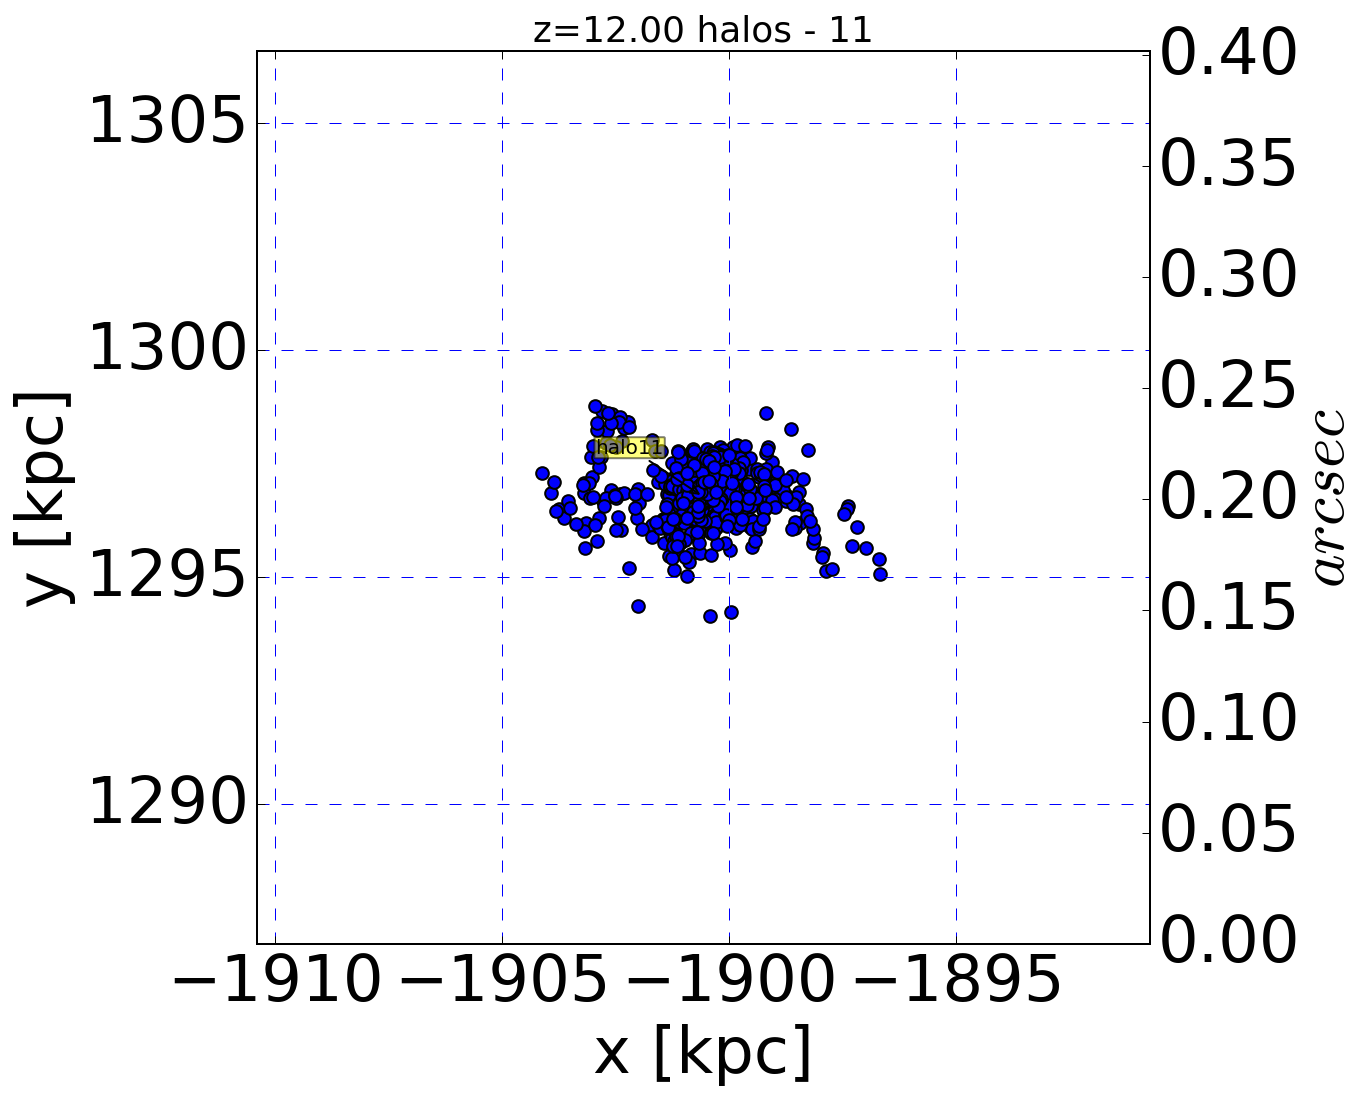

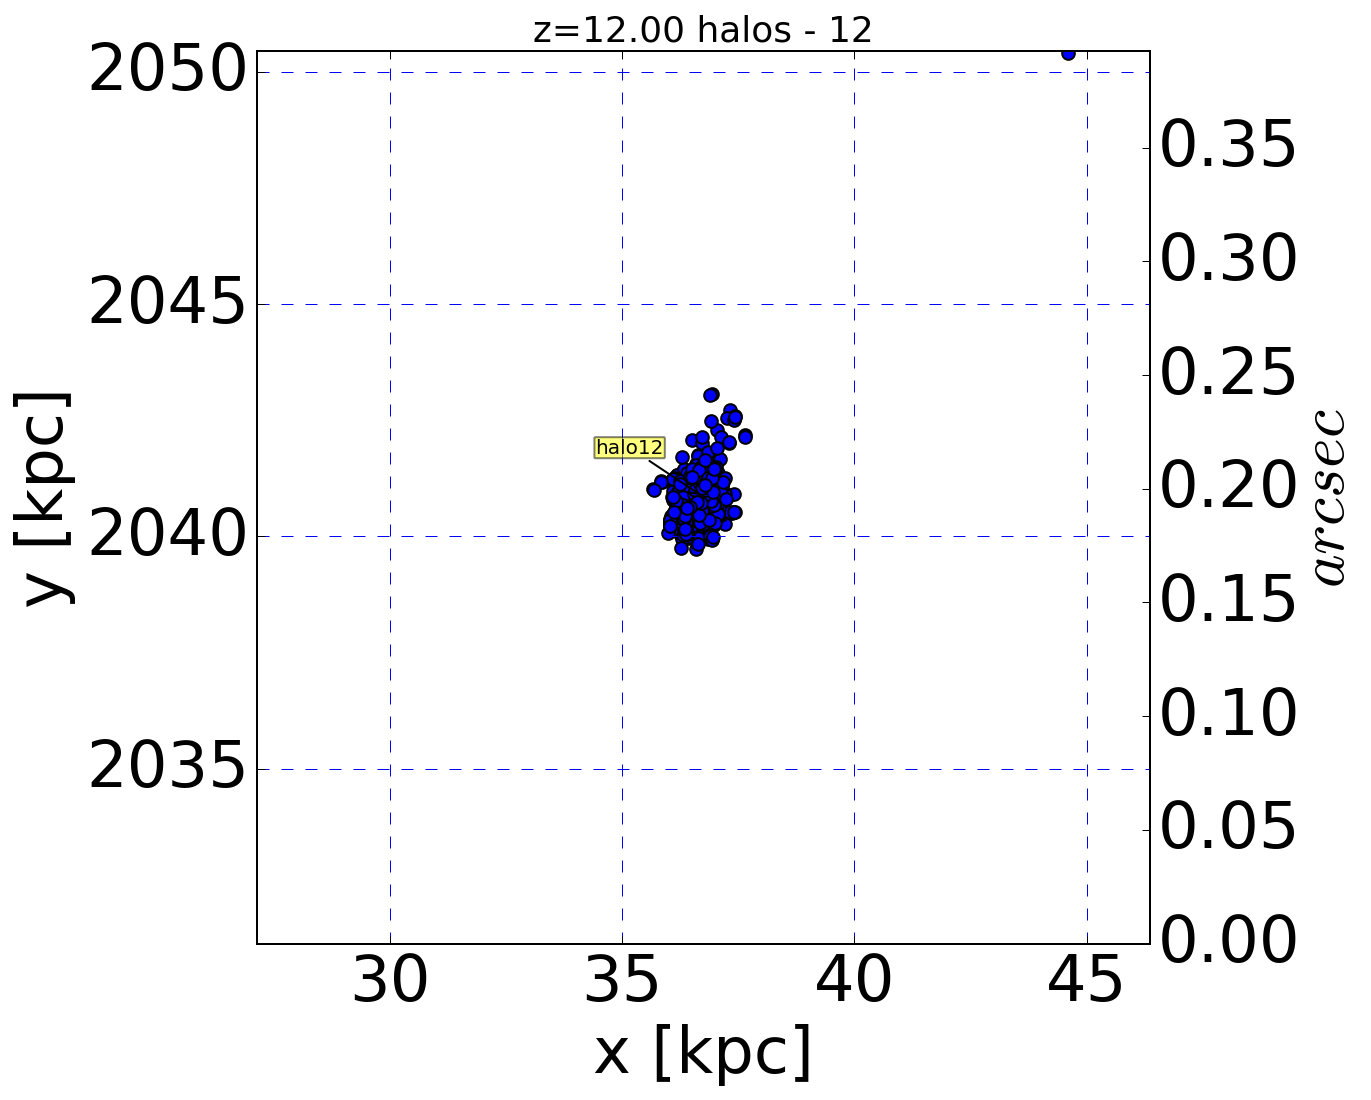

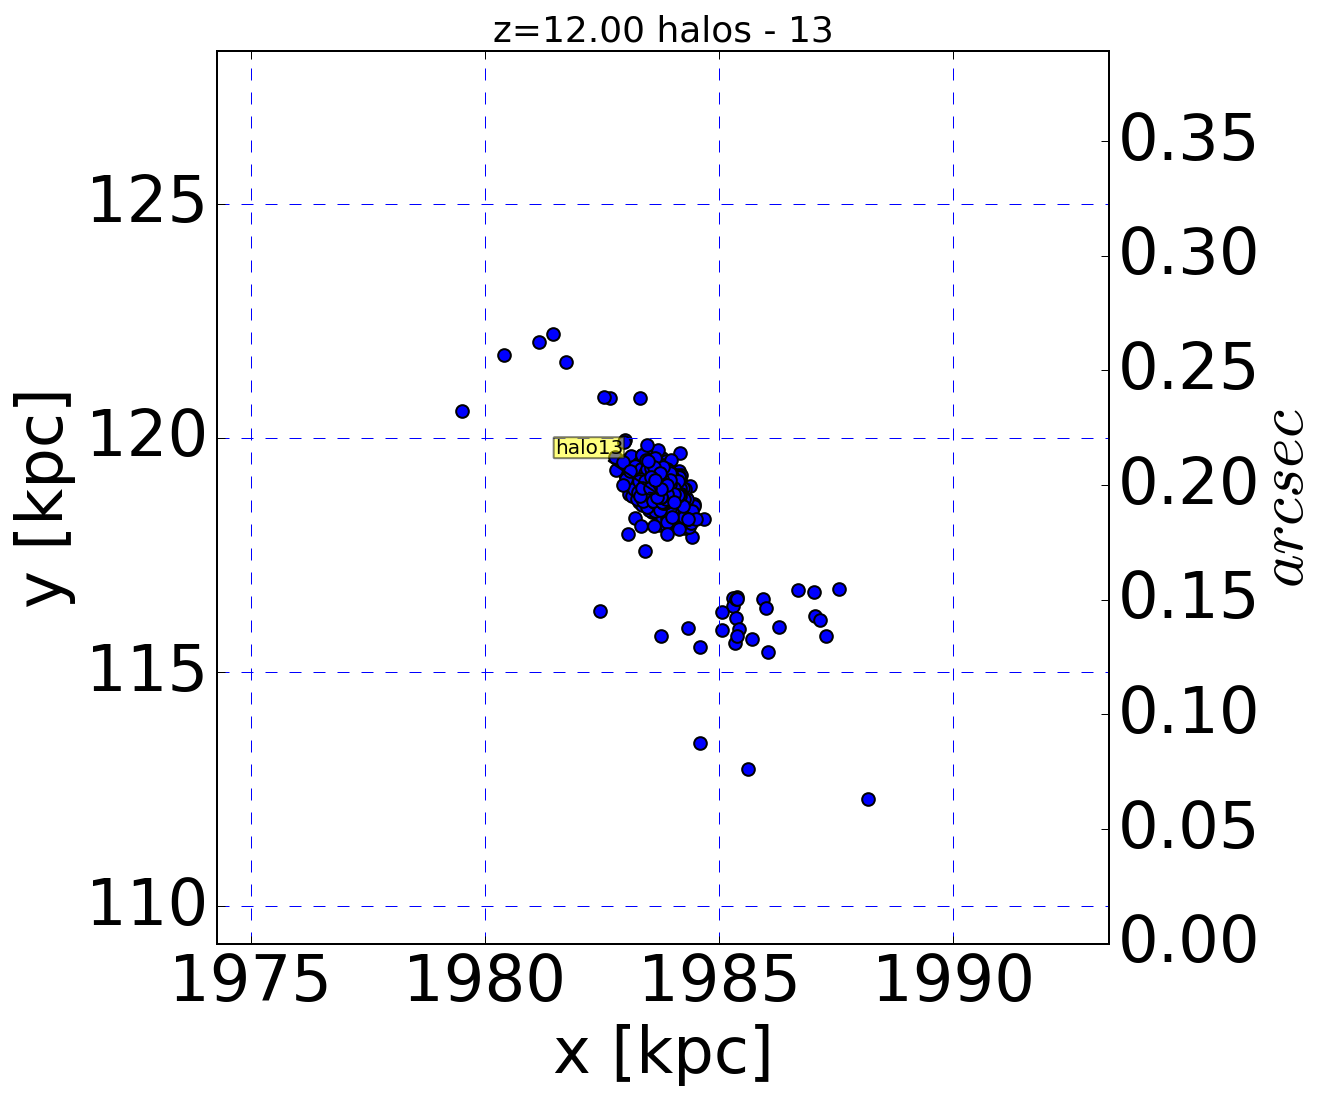

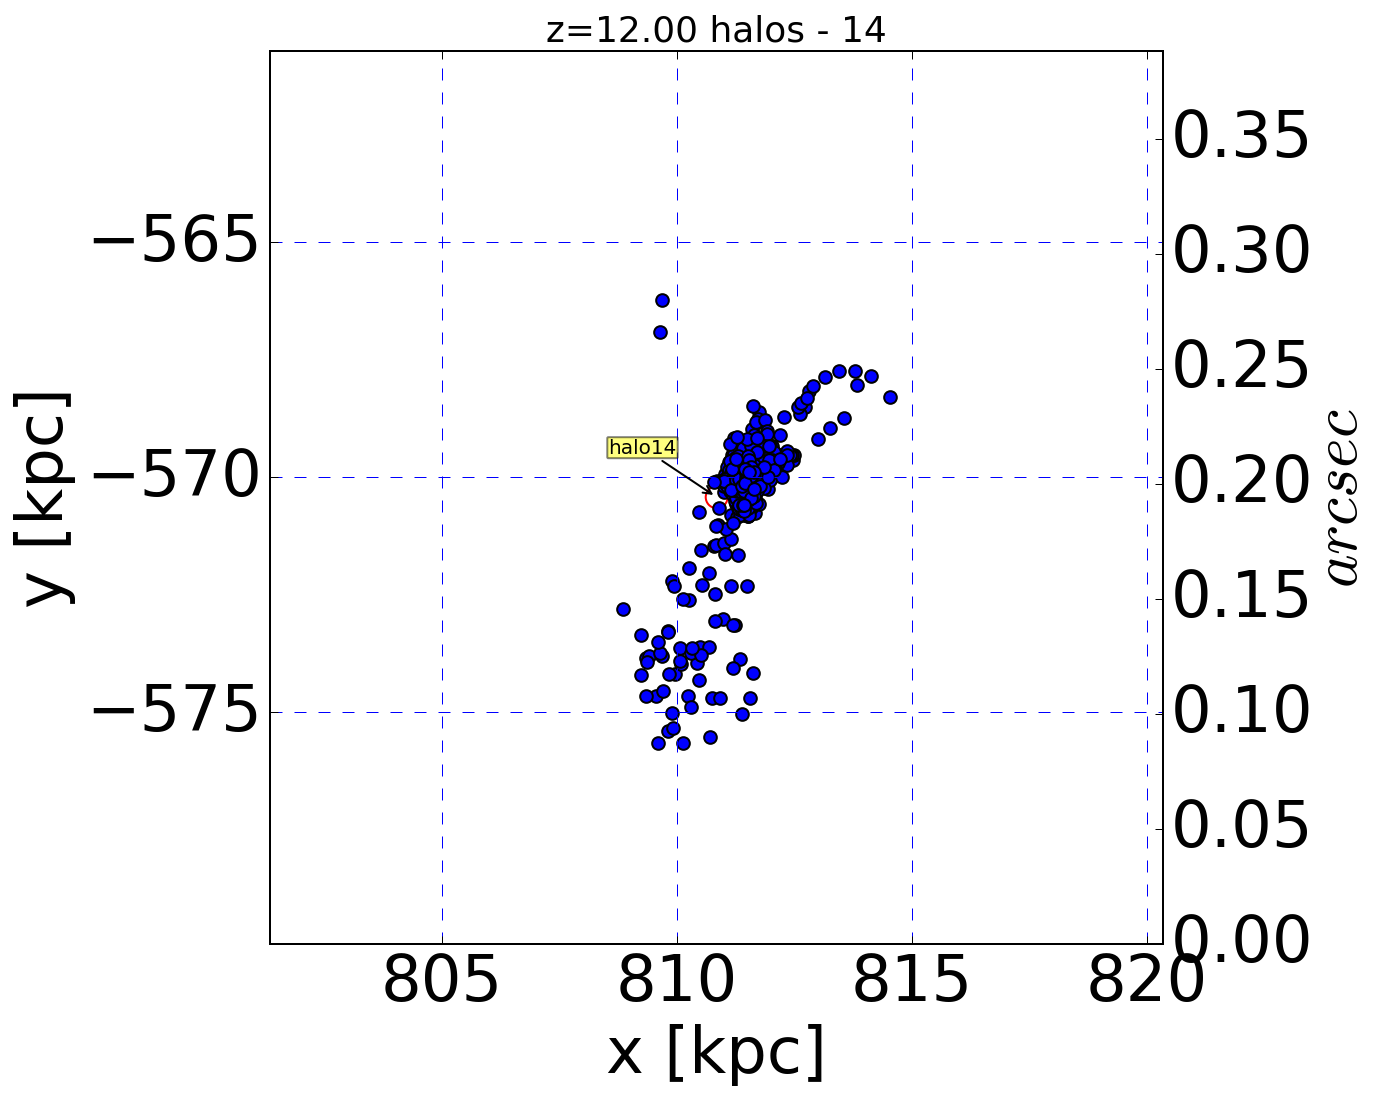

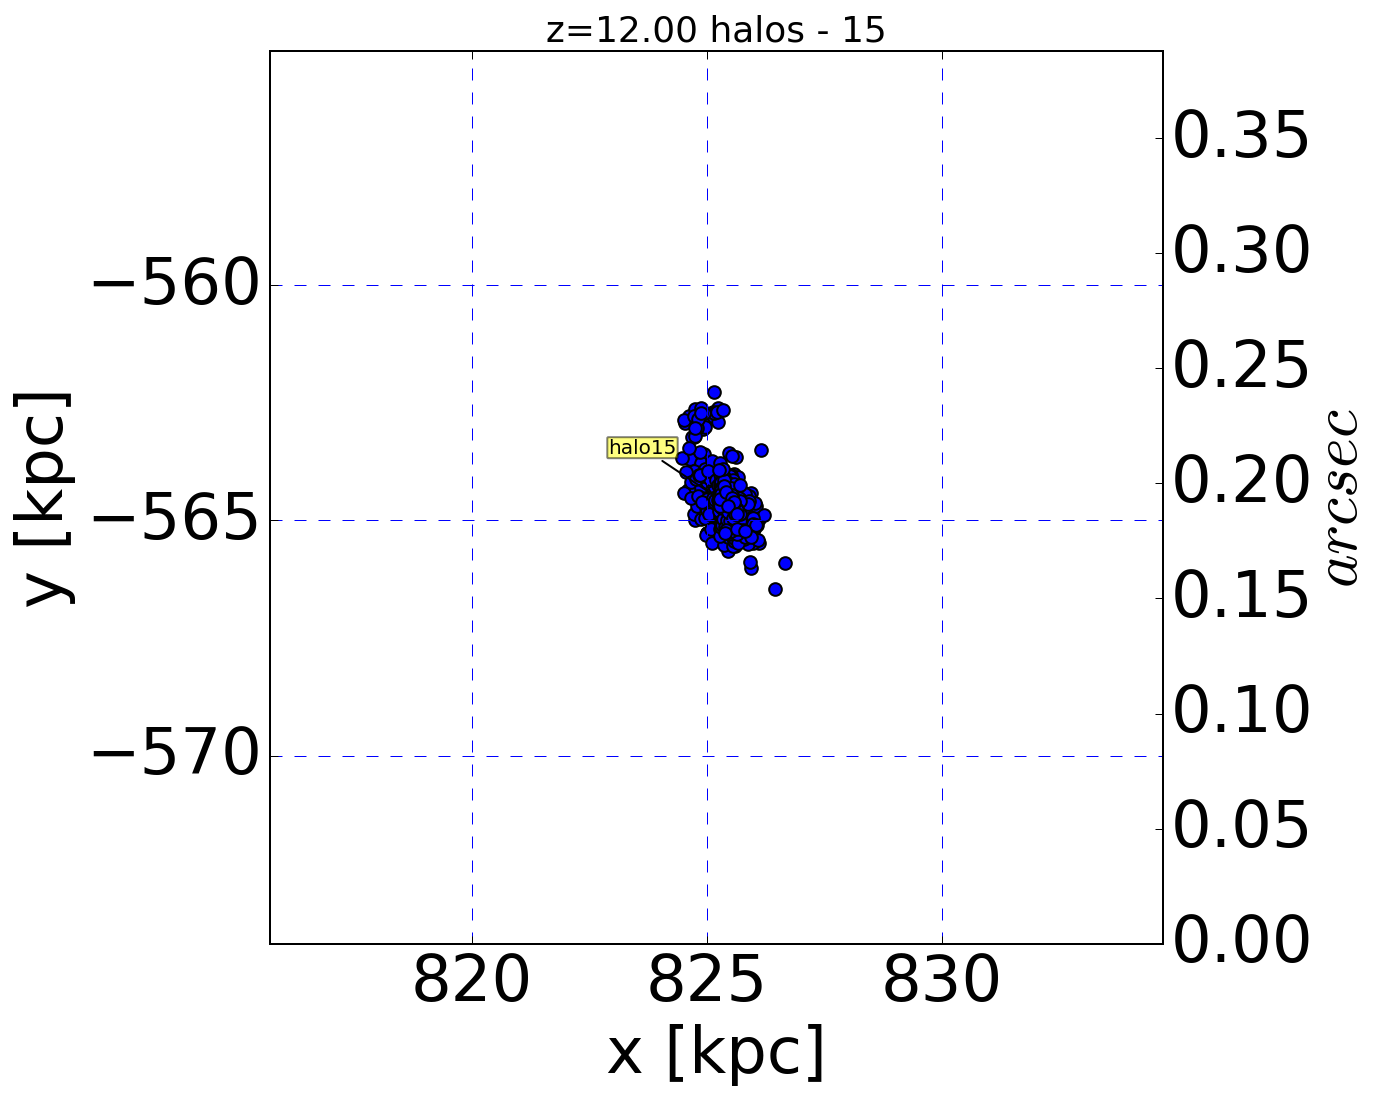

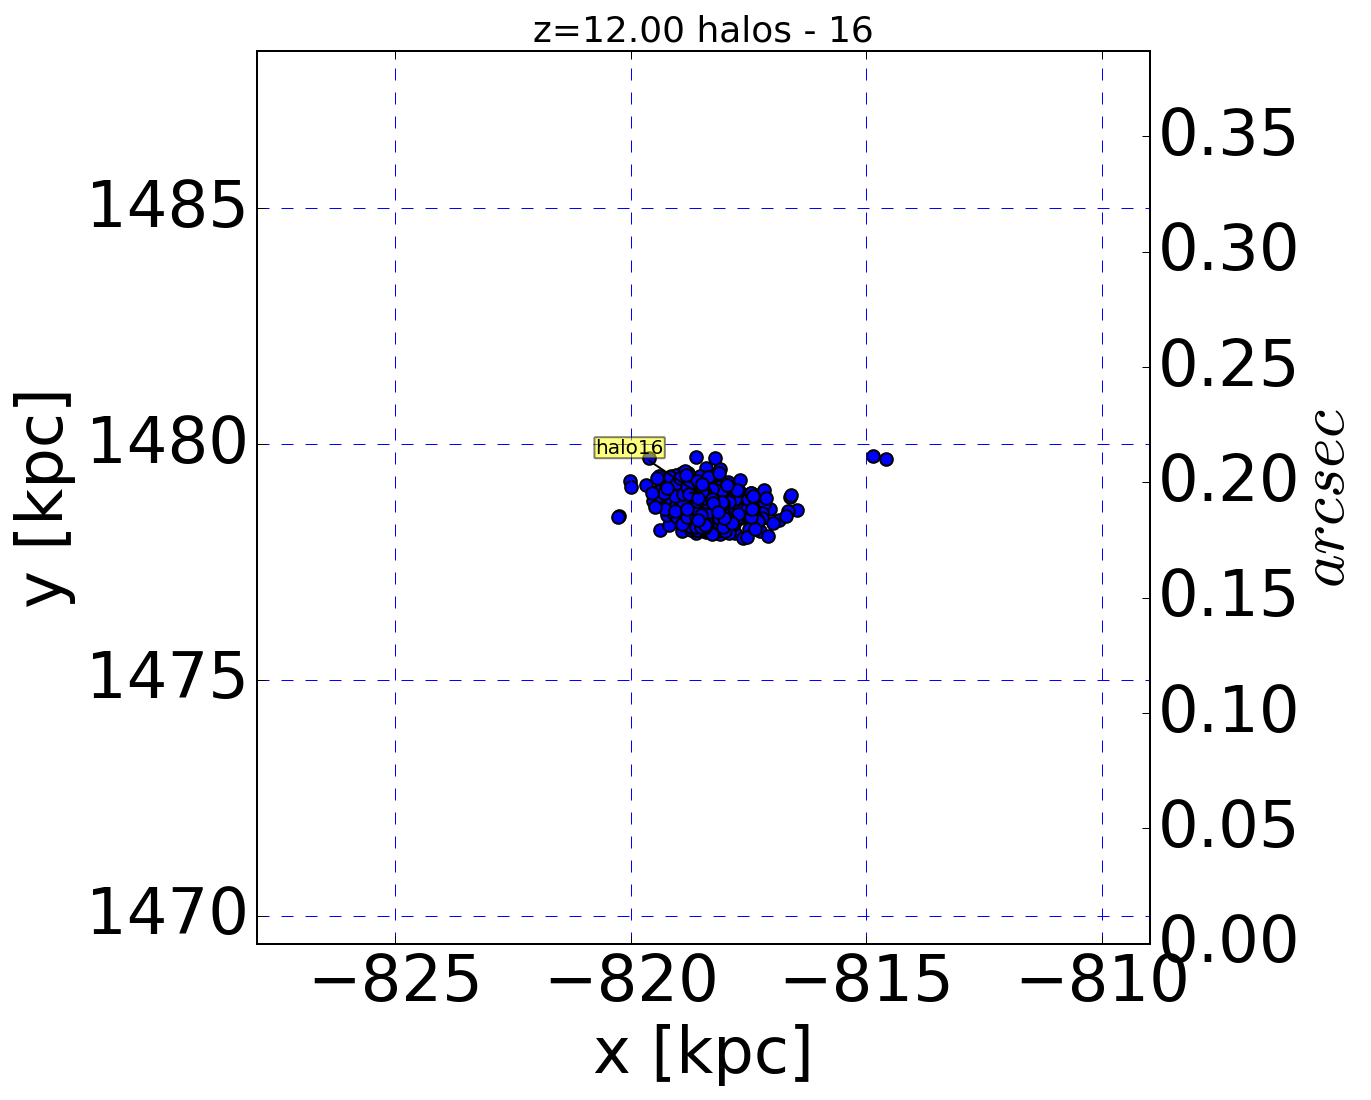

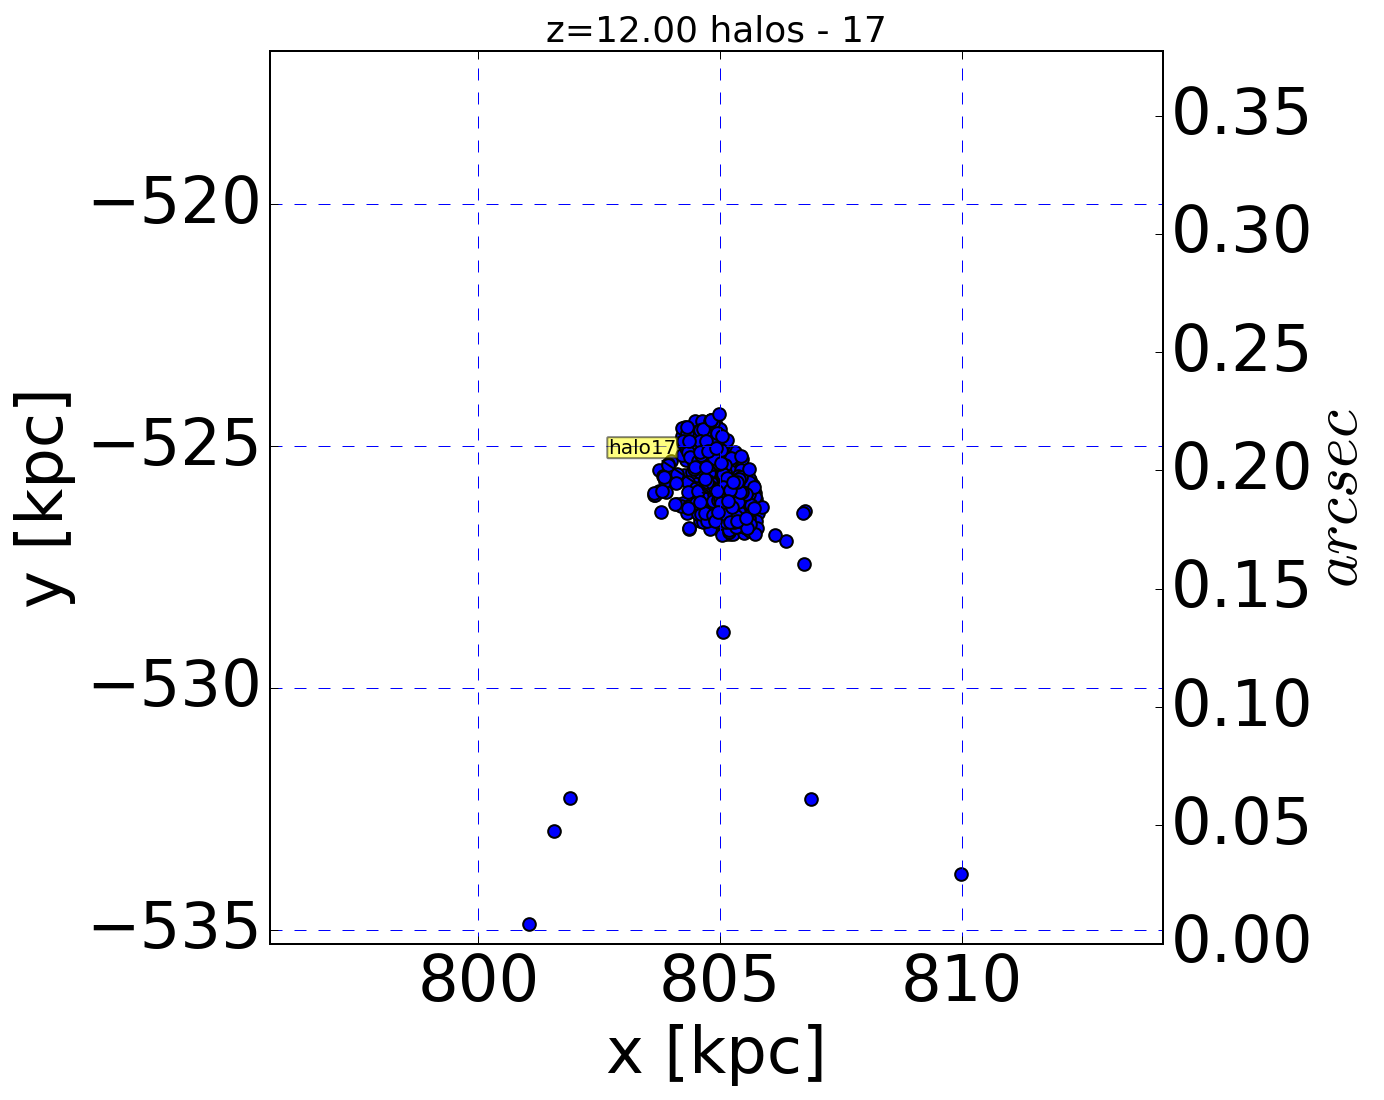

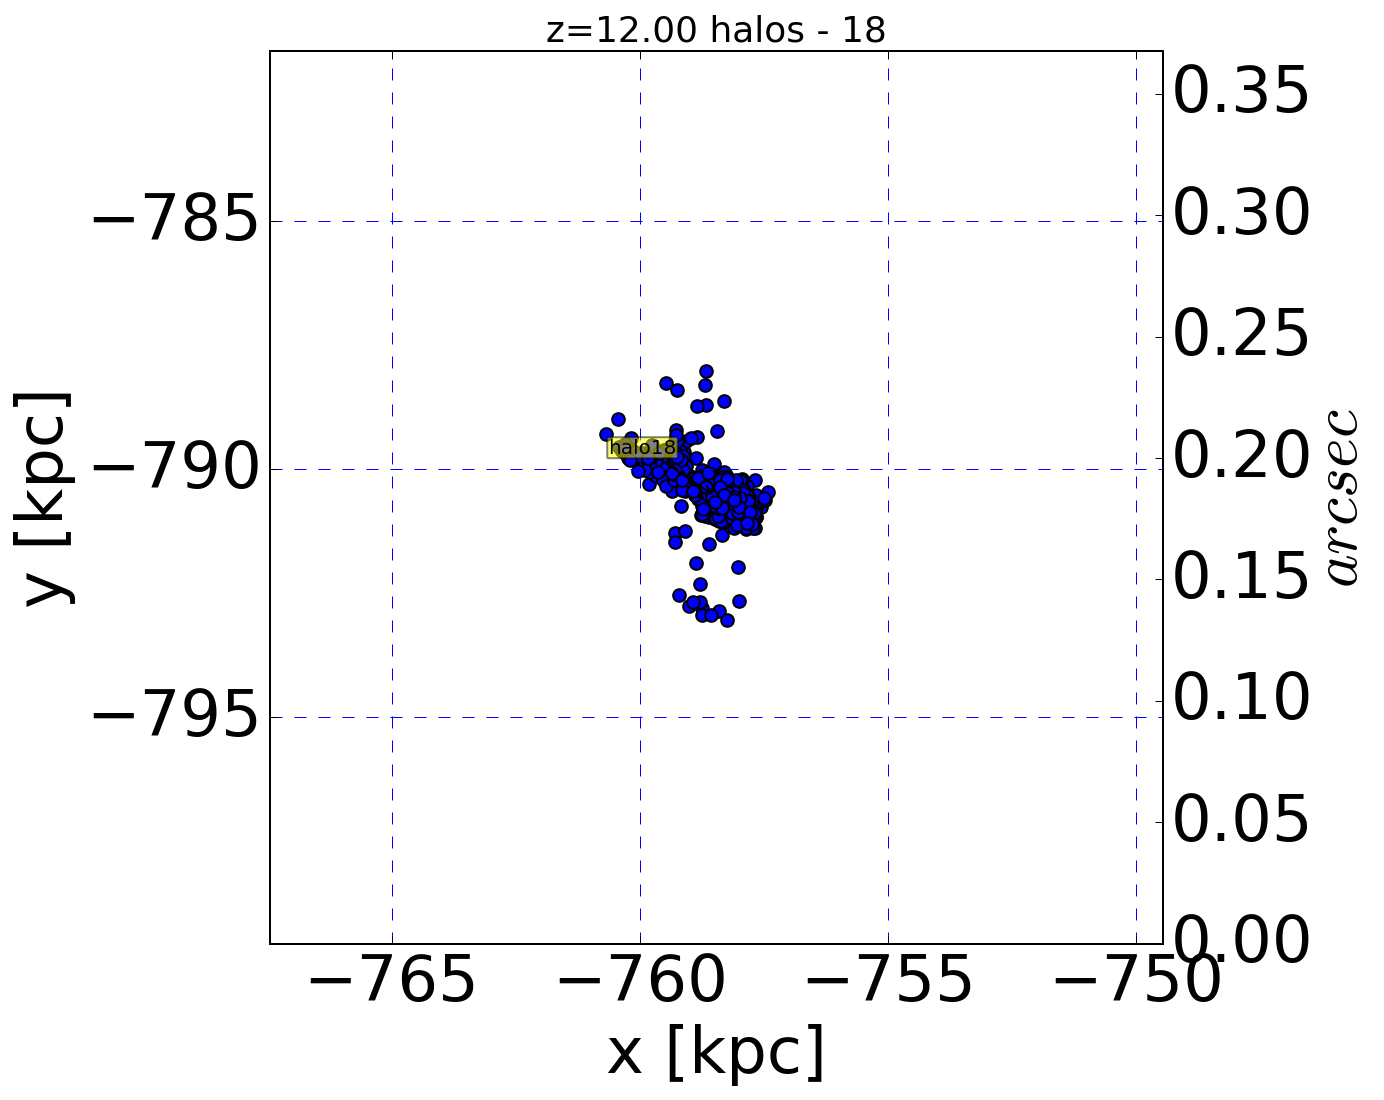

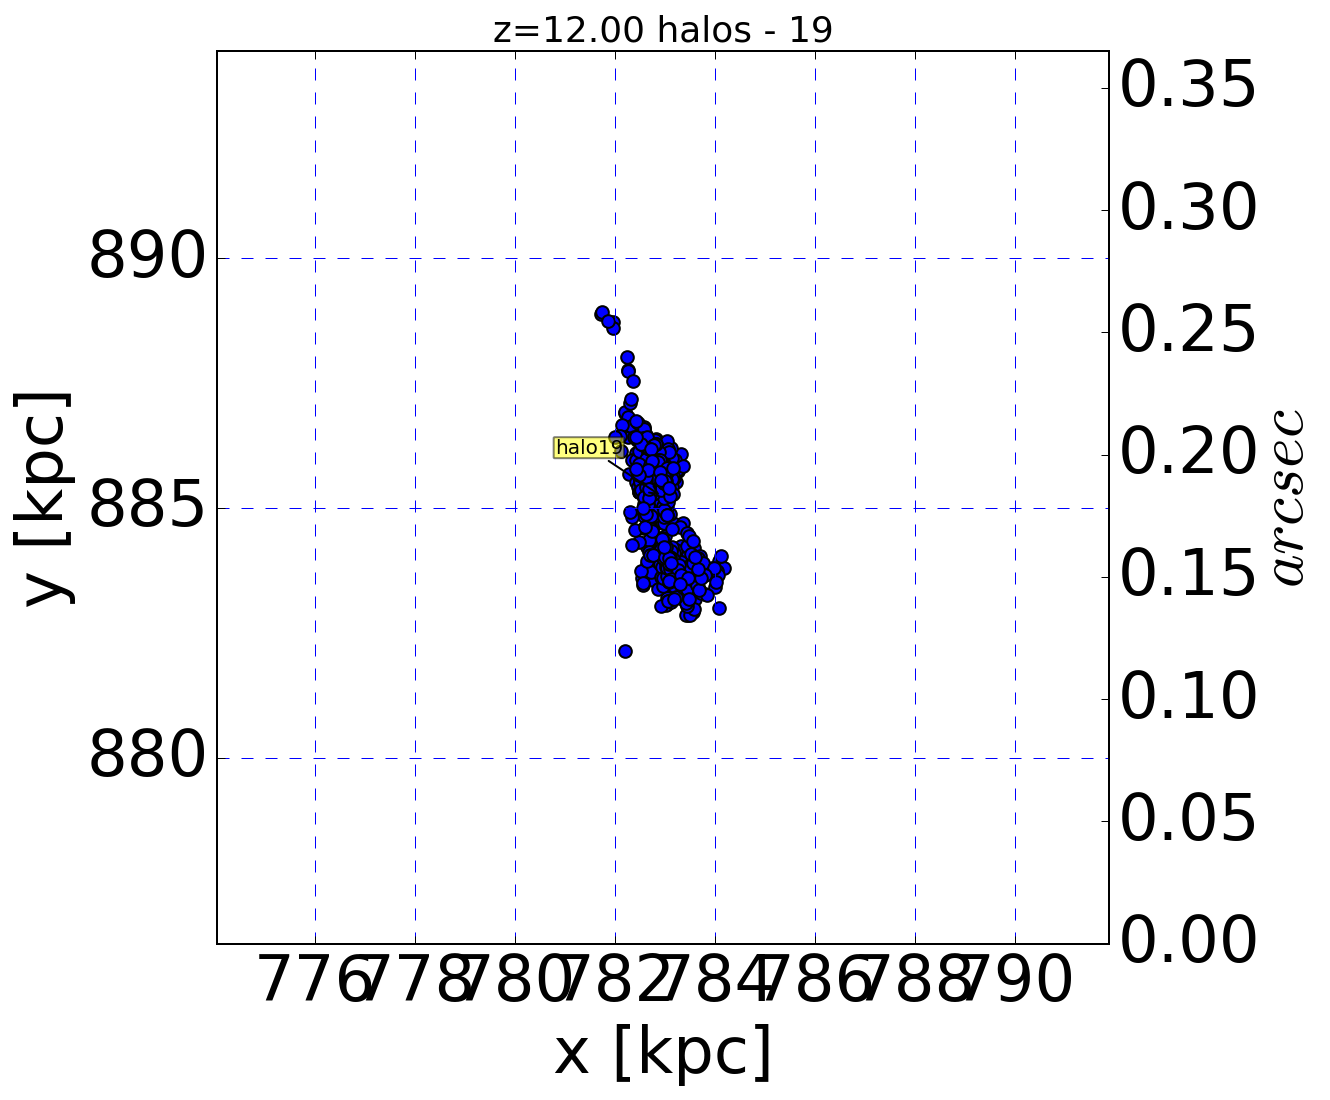

In [28]:
fig = plt.figure(figsize=(8,8))
for halo in range(0,20):
    arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
    radiusScaleFac = 1.0
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    print('radius {:.2f}'.format(radius))

    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    plt.savefig('/Users/earnric/Desktop/SP-galaxy_z_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    del ax
gc.collect()